<a href="https://colab.research.google.com/github/konkuk-gaegul/3rd-Team-Project/blob/main/Pytorch_retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 리트리버 학습
- 11개 이미지 세트 중, 가장 성능이 좋은 set 5를 대표로 업로드
- Loss : 0.1917, Acc : 94.5%

## 이미지 전처리 설명
**set_1** 
- 이미지를 선명하게 해줌  

**set_2** 
- 가우시안 블러를 적용

**set_3**
- 흑백 처리 후 선명하게 함

**set_4**
- 흑백 처리 후 가우시안 블러 적용

**set_5**
- 선명한 이미지의 대비를 높이기 위해 yuv적용 (RGB로 바꾸지 않음)

**set_6**
- 색상 값 / 255 로 스케일링 하여 색상값이 0~1 사이의 값을 가지도록 함

**set_7**
- 흑백 처리 후 가우시안 블러처리를 한 이미지에 캐니 경계선 감지기 적용

**set_8**
- 원본 이미지를 정방형으로 자른 후 선명하고, yuv 적용

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time

import os, shutil
import matplotlib as plt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [ ]:
base_dir = '/home/tutor/안재형/dog_pic/리트리버/set_5'

# # 훈련셋, 검증셋, 테스트셋을 미리 분할하기 위한 폴더 경로
train_path = os.path.join(base_dir, 'train')
os.mkdir( train_path)

test_path = os.path.join(base_dir, 'test')
os.mkdir( test_path)

# # train 정상 폴더
train_nor_path = os.path.join(train_path, 'nor')
os.mkdir( train_nor_path)

# # train 비만 폴더
train_fat_path = os.path.join(train_path, 'fat')
os.mkdir( train_fat_path)

# # test 정상 폴더
test_nor_path = os.path.join(test_path, 'nor')
os.mkdir( test_nor_path)

# # test 비만 폴더
test_fat_path = os.path.join(test_path, 'fat')
os.mkdir( test_fat_path)

In [ ]:
base_dir = '/home/tutor/안재형/dog_pic/리트리버/set_5'

nor_path = os.path.join(base_dir, '전처리_정상')
fat_path = os.path.join(base_dir, '전처리_비만')

nor_list = os.listdir(nor_path)
fat_list = os.listdir(fat_path)

print(len(nor_list))
print(len(fat_list))

577
408


In [ ]:
# train : 75%, test : 25%
# 정상 이미지 복사
for i in range(len(nor_list)):
    src_path = os.path.join(nor_path, nor_list[i])
    
    if i < len(nor_list)*0.75:
        dst_path = os.path.join(train_nor_path, f'nor_{i}.jpg')
        shutil.copyfile( src_path, dst_path )
    else :
        dst_path = os.path.join(test_nor_path, f'nor_{i}.jpg')
        shutil.copyfile( src_path, dst_path )
                                
# 비만 이미지 복사
for i in range(len(fat_list)):
    src_path = os.path.join(fat_path, fat_list[i])
    
    if i < len(fat_list)*0.75:
        dst_path = os.path.join(train_fat_path, f'fat_{i}.jpg')
        shutil.copyfile( src_path, dst_path )
    else :
        dst_path = os.path.join(test_fat_path, f'fat_{i}.jpg')
        shutil.copyfile( src_path, dst_path )

In [ ]:
print( len( os.listdir(train_nor_path) ) )
print( len( os.listdir(train_fat_path) ) )
print( len( os.listdir(test_nor_path) ) )
print( len( os.listdir(test_fat_path) ) )

433
306
144
102


# 학습 1
- pytorch로 학습 수행
- 다양한 batch_size, epoch, 이미지 전처리 등으로 최적의 성능을 뽑아낸다.
- 리트리버 set_5로 진행
    - 선명한 이미지의 대비를 높이기 위해 yuv적용 (RGB로 바꾸지 않음)
- batch size를 5부터 20까지 실행
- 이미지 전처리 수행

In [ ]:
# Loss_Accuracy에 각 배치 사이즈마다의 성능을 넣어둔다
Loss_Accuracy = []

In [ ]:
for batch in range(5, 21):
    # 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
    # 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 일부 변경
    transforms_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
    ])

    transforms_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    data_dir = '/home/tutor/안재형/dog_pic/리트리버/set_5'
    train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
    test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

    train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch, shuffle=True, num_workers=2)
    test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=batch, shuffle=True, num_workers=2)

    print('학습 데이터셋 크기:', len(train_datasets))
    print('테스트 데이터셋 크기:', len(test_datasets))

    class_names = train_datasets.classes
    print('클래스:', class_names)
    
    #--------------------------------------------#
    
    model = models.resnet34(pretrained=True)
    num_features = model.fc.in_features
    # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 2개로 교체하여 마지막 레이어 다시 학습
    model.fc = nn.Linear(num_features, 2)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    #--------------------------------------------#
    print(f'-------------현재 batch_size는 {batch}-------------')
    num_epochs = 50
    model.train()
    start_time = time.time()

    # 전체 반복(epoch) 수 만큼 반복하며
    for epoch in range(num_epochs):
        running_loss = 0.
        running_corrects = 0

        # 배치 단위로 학습 데이터 불러오기
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델에 입력(forward)하고 결과 계산
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_datasets)
        epoch_acc = running_corrects / len(train_datasets) * 100.

        # 학습 과정 중에 결과 출력
        print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
        
    #--------------------------------------------#
        
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
            print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
#             imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

        epoch_loss = running_loss / len(test_datasets)
        epoch_acc = running_corrects / len(test_datasets) * 100.
        print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))
        
        Loss_Accuracy.append([batch, epoch_loss, epoch_acc])
    # 리트리버 set5의 Batch size가 {batch}인 학습 1의 경우를 의미
    torch.save(model, f'ret_set5_B_{batch}_1.pth')
print( Loss_Accuracy )

학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 batch_size는 5-------------
#0 Loss: 0.7102 Acc: 67.1177% Time: 5.9539s
#1 Loss: 0.5850 Acc: 76.3194% Time: 11.7813s
#2 Loss: 0.4834 Acc: 80.3789% Time: 17.6404s
#3 Loss: 0.3712 Acc: 85.5210% Time: 23.4860s
#4 Loss: 0.3907 Acc: 86.0622% Time: 29.3711s
#5 Loss: 0.3125 Acc: 87.5507% Time: 35.2619s
#6 Loss: 0.4026 Acc: 86.8742% Time: 41.1269s
#7 Loss: 0.2969 Acc: 90.3924% Time: 46.9996s
#8 Loss: 0.2608 Acc: 89.9865% Time: 52.8669s
#9 Loss: 0.2502 Acc: 92.0162% Time: 58.7766s
#10 Loss: 0.2355 Acc: 92.0162% Time: 64.7088s
#11 Loss: 0.2358 Acc: 91.8809% Time: 70.6648s
#12 Loss: 0.1197 Acc: 95.5345% Time: 76.6281s
#13 Loss: 0.1336 Acc: 96.0758% Time: 82.5564s
#14 Loss: 0.2090 Acc: 92.6928% Time: 88.5012s
#15 Loss: 0.1444 Acc: 95.3992% Time: 94.4755s
#16 Loss: 0.1251 Acc: 96.3464% Time: 100.5021s
#17 Loss: 0.1321 Acc: 96.2111% Time: 106.5047s
#18 Loss: 0.0824 Acc: 97.5643% Time: 112.5735s
#19 Loss: 0.0978 Acc: 96.8877% Time: 1

#18 Loss: 0.0827 Acc: 97.1583% Time: 108.9199s
#19 Loss: 0.0648 Acc: 98.5115% Time: 114.6250s
#20 Loss: 0.1024 Acc: 97.1583% Time: 120.4065s
#21 Loss: 0.0434 Acc: 98.3762% Time: 126.1171s
#22 Loss: 0.0537 Acc: 98.3762% Time: 131.8365s
#23 Loss: 0.0202 Acc: 99.3234% Time: 137.5490s
#24 Loss: 0.0262 Acc: 99.1881% Time: 143.2887s
#25 Loss: 0.0373 Acc: 98.5115% Time: 149.0153s
#26 Loss: 0.0662 Acc: 98.3762% Time: 154.7431s
#27 Loss: 0.0218 Acc: 99.4587% Time: 160.4953s
#28 Loss: 0.0358 Acc: 98.6468% Time: 166.1987s
#29 Loss: 0.0524 Acc: 98.3762% Time: 171.9781s
#30 Loss: 0.0229 Acc: 99.4587% Time: 177.7923s
#31 Loss: 0.0260 Acc: 98.7821% Time: 183.4734s
#32 Loss: 0.0295 Acc: 99.1881% Time: 189.1713s
#33 Loss: 0.0218 Acc: 99.1881% Time: 194.9025s
#34 Loss: 0.0255 Acc: 99.3234% Time: 200.6163s
#35 Loss: 0.0323 Acc: 98.7821% Time: 206.3362s
#36 Loss: 0.0112 Acc: 99.7294% Time: 212.0471s
#37 Loss: 0.0118 Acc: 99.5940% Time: 217.7400s
#38 Loss: 0.0179 Acc: 99.5940% Time: 223.4424s
#39 Loss: 0.0

[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.1917 Acc: 94.3089% Time: 1.0101s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 batch_size는 10-------------
#0 Loss: 0.5603 Acc: 70.7713% Time: 5.2250s
#1 Loss: 0.3533 Acc: 85.5210% Time: 10.5133s
#2 Loss: 0.2688 Acc: 88.6333% Time: 15.7509s
#3 Loss: 0.2361 Acc: 90.7984% Time: 20.8421s
#4 Loss: 0.1861 Acc:

#27 Loss: 0.0315 Acc: 98.9175% Time: 144.4668s
#28 Loss: 0.0397 Acc: 98.5115% Time: 149.7691s
#29 Loss: 0.0170 Acc: 99.3234% Time: 154.9058s
#30 Loss: 0.0109 Acc: 99.5940% Time: 160.0063s
#31 Loss: 0.0168 Acc: 99.4587% Time: 165.1495s
#32 Loss: 0.0127 Acc: 99.5940% Time: 170.2307s
#33 Loss: 0.0196 Acc: 99.3234% Time: 175.3288s
#34 Loss: 0.0232 Acc: 98.7821% Time: 180.4180s
#35 Loss: 0.0280 Acc: 99.3234% Time: 185.6792s
#36 Loss: 0.0104 Acc: 99.7294% Time: 190.8725s
#37 Loss: 0.0264 Acc: 99.3234% Time: 195.9721s
#38 Loss: 0.0188 Acc: 99.3234% Time: 201.1117s
#39 Loss: 0.0179 Acc: 99.0528% Time: 206.2434s
#40 Loss: 0.0213 Acc: 99.0528% Time: 211.3282s
#41 Loss: 0.0174 Acc: 99.5940% Time: 216.4715s
#42 Loss: 0.0090 Acc: 99.4587% Time: 221.7323s
#43 Loss: 0.0192 Acc: 99.1881% Time: 226.9072s
#44 Loss: 0.0210 Acc: 99.3234% Time: 231.9454s
#45 Loss: 0.0118 Acc: 99.4587% Time: 237.0442s
#46 Loss: 0.0254 Acc: 99.1881% Time: 242.0509s
#47 Loss: 0.0265 Acc: 99.0528% Time: 247.2390s
#48 Loss: 0.0

#12 Loss: 0.0526 Acc: 98.2409% Time: 63.3821s
#13 Loss: 0.0436 Acc: 98.5115% Time: 68.2148s
#14 Loss: 0.0305 Acc: 99.0528% Time: 73.0602s
#15 Loss: 0.0253 Acc: 99.1881% Time: 78.2205s
#16 Loss: 0.0367 Acc: 98.6468% Time: 82.9566s
#17 Loss: 0.0842 Acc: 97.5643% Time: 87.8733s
#18 Loss: 0.0929 Acc: 97.0230% Time: 92.9177s
#19 Loss: 0.1103 Acc: 96.0758% Time: 97.9349s
#20 Loss: 0.0541 Acc: 97.8349% Time: 102.7017s
#21 Loss: 0.0538 Acc: 98.2409% Time: 107.5469s
#22 Loss: 0.0381 Acc: 99.1881% Time: 112.4943s
#23 Loss: 0.0534 Acc: 98.3762% Time: 117.4247s
#24 Loss: 0.0506 Acc: 97.9702% Time: 122.4618s
#25 Loss: 0.0386 Acc: 98.3762% Time: 127.2508s
#26 Loss: 0.0314 Acc: 99.1881% Time: 132.4628s
#27 Loss: 0.1242 Acc: 96.7524% Time: 137.5505s
#28 Loss: 0.0443 Acc: 98.7821% Time: 142.3828s
#29 Loss: 0.0256 Acc: 99.1881% Time: 147.3828s
#30 Loss: 0.0284 Acc: 98.9175% Time: 152.1239s
#31 Loss: 0.0165 Acc: 99.4587% Time: 157.0663s
#32 Loss: 0.0207 Acc: 99.3234% Time: 161.9741s
#33 Loss: 0.0125 Acc:

#2 Loss: 0.3172 Acc: 86.0622% Time: 15.6145s
#3 Loss: 0.2332 Acc: 90.3924% Time: 20.8063s
#4 Loss: 0.1794 Acc: 93.6401% Time: 26.1202s
#5 Loss: 0.1670 Acc: 93.6401% Time: 31.3159s
#6 Loss: 0.1213 Acc: 94.9932% Time: 36.6581s
#7 Loss: 0.1164 Acc: 96.2111% Time: 41.8438s
#8 Loss: 0.0951 Acc: 96.0758% Time: 47.0104s
#9 Loss: 0.0824 Acc: 97.0230% Time: 52.1588s
#10 Loss: 0.1033 Acc: 96.3464% Time: 57.3150s
#11 Loss: 0.1636 Acc: 95.6698% Time: 62.5898s
#12 Loss: 0.0644 Acc: 97.0230% Time: 67.7895s
#13 Loss: 0.0565 Acc: 97.5643% Time: 73.2110s
#14 Loss: 0.0538 Acc: 97.9702% Time: 78.3283s
#15 Loss: 0.0577 Acc: 97.6996% Time: 83.7054s
#16 Loss: 0.0573 Acc: 97.4290% Time: 88.9495s
#17 Loss: 0.0570 Acc: 97.6996% Time: 94.0557s
#18 Loss: 0.0595 Acc: 98.2409% Time: 99.2566s
#19 Loss: 0.0124 Acc: 99.7294% Time: 104.3864s
#20 Loss: 0.0418 Acc: 98.5115% Time: 109.6306s
#21 Loss: 0.0389 Acc: 98.3762% Time: 114.9122s
#22 Loss: 0.0448 Acc: 98.1055% Time: 120.0649s
#23 Loss: 0.0736 Acc: 97.6996% Time: 1

[[5, 0.32808656001240405, tensor(91.8699, device='cuda:0')], [6, 0.3622625100592481, tensor(91.8699, device='cuda:0')], [7, 0.35845476735581483, tensor(92.6829, device='cuda:0')], [8, 0.298504257616322, tensor(91.8699, device='cuda:0')], [9, 0.19171841152398506, tensor(94.3089, device='cuda:0')], [10, 0.25149055655167357, tensor(93.4959, device='cuda:0')], [11, 0.36617710030395384, tensor(91.0569, device='cuda:0')], [12, 0.33526861287721593, tensor(91.8699, device='cuda:0')], [13, 0.29604436570165177, tensor(92.2764, device='cuda:0')], [14, 0.32727507164898684, tensor(91.8699, device='cuda:0')], [15, 0.238802542932695, tensor(93.9024, device='cuda:0')], [16, 0.26581978348909113, tensor(95.1219, device='cuda:0')], [17, 0.28264929994759036, tensor(94.7154, device='cuda:0')], [18, 0.35929426152213684, tensor(93.9024, device='cuda:0')], [19, 0.24946958038797276, tensor(94.3089, device='cuda:0')], [20, 0.2959801397717944, tensor(92.6829, device='cuda:0')]]


In [ ]:
for i in range(10):
    print(f'batch가 {Loss_Accuracy[i][0]}인 경우 Loss는 {Loss_Accuracy[i][1]}')

batch가 5인 경우 Loss는 0.32808656001240405
batch가 6인 경우 Loss는 0.3622625100592481
batch가 7인 경우 Loss는 0.35845476735581483
batch가 8인 경우 Loss는 0.298504257616322
batch가 9인 경우 Loss는 0.19171841152398506
batch가 10인 경우 Loss는 0.25149055655167357
batch가 11인 경우 Loss는 0.36617710030395384
batch가 12인 경우 Loss는 0.33526861287721593
batch가 13인 경우 Loss는 0.29604436570165177
batch가 14인 경우 Loss는 0.32727507164898684


- set 3과 비슷하게 대체로 batch_size = 9 전후로 성능이 가장 좋은 모습을 보인다

# 학습 2
- batch_size는 9
- epoch를 30, 50, 75, 100 으로 해보자

In [ ]:
# 빈 문자열에 각 배치 사이즈마다의 성능을 넣어둔다
Loss_Accuracy = []
Epoch = [30, 50, 75, 100]

In [ ]:
for epoch in Epoch:
    # 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
    # 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 일부 변경
    transforms_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
    ])

    transforms_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    data_dir = '/home/tutor/안재형/dog_pic/리트리버/set_5'
    train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
    test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

    train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=9, shuffle=True, num_workers=2)
    test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=9, shuffle=True, num_workers=2)

    print('학습 데이터셋 크기:', len(train_datasets))
    print('테스트 데이터셋 크기:', len(test_datasets))

    class_names = train_datasets.classes
    print('클래스:', class_names)
    
    #--------------------------------------------#
    
    model = models.resnet34(pretrained=True)
    num_features = model.fc.in_features
    # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 2개로 교체하여 마지막 레이어 다시 학습
    model.fc = nn.Linear(num_features, 2)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    #--------------------------------------------#
    print(f'-------------현재 학습의 Epoch는 {epoch}-------------')
    num_epochs = epoch
    model.train()
    start_time = time.time()

    # 전체 반복(epoch) 수 만큼 반복하며
    for epoch in range(num_epochs):
        running_loss = 0.
        running_corrects = 0

        # 배치 단위로 학습 데이터 불러오기
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델에 입력(forward)하고 결과 계산
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_datasets)
        epoch_acc = running_corrects / len(train_datasets) * 100.

        # 학습 과정 중에 결과 출력
        print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
        
    #--------------------------------------------#
        
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
            print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
#             imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

        epoch_loss = running_loss / len(test_datasets)
        epoch_acc = running_corrects / len(test_datasets) * 100.
        print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))
        
        Loss_Accuracy.append([epoch, epoch_loss, epoch_acc])
    # 리트리버 set5의 Batch size가 {batch}인 학습 1의 경우를 의미
    torch.save(model, f'ret_set5_E_{epoch}_2.pth')
print( Loss_Accuracy )

학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 학습의 Epoch는 30-------------
#0 Loss: 0.6916 Acc: 63.7348% Time: 5.4027s
#1 Loss: 0.4336 Acc: 79.1610% Time: 10.7978s
#2 Loss: 0.3579 Acc: 86.7388% Time: 16.0413s
#3 Loss: 0.2737 Acc: 87.9567% Time: 21.3541s
#4 Loss: 0.2480 Acc: 90.5277% Time: 26.7116s
#5 Loss: 0.1740 Acc: 93.0988% Time: 32.0164s
#6 Loss: 0.1333 Acc: 94.9932% Time: 37.3571s
#7 Loss: 0.1918 Acc: 92.4222% Time: 42.6771s
#8 Loss: 0.1724 Acc: 94.1813% Time: 48.0149s
#9 Loss: 0.1285 Acc: 95.3992% Time: 53.4665s
#10 Loss: 0.1090 Acc: 95.9405% Time: 58.7883s
#11 Loss: 0.0980 Acc: 95.8051% Time: 64.2649s
#12 Loss: 0.1095 Acc: 95.6698% Time: 69.8511s
#13 Loss: 0.1154 Acc: 96.4817% Time: 75.2611s
#14 Loss: 0.1057 Acc: 96.8877% Time: 80.7157s
#15 Loss: 0.0772 Acc: 97.1583% Time: 86.1163s
#16 Loss: 0.0808 Acc: 96.8877% Time: 91.4550s
#17 Loss: 0.0843 Acc: 96.6171% Time: 96.8833s
#18 Loss: 0.0849 Acc: 97.2936% Time: 102.5261s
#19 Loss: 0.1849 Acc: 94.5873% Time: 108

#57 Loss: 0.0111 Acc: 99.4587% Time: 323.2566s
#58 Loss: 0.0200 Acc: 99.5940% Time: 328.7159s
#59 Loss: 0.0111 Acc: 99.5940% Time: 334.2847s
#60 Loss: 0.0773 Acc: 98.1055% Time: 339.9066s
#61 Loss: 0.0122 Acc: 99.7294% Time: 345.3728s
#62 Loss: 0.0352 Acc: 99.5940% Time: 350.9596s
#63 Loss: 0.0277 Acc: 99.0528% Time: 356.5003s
#64 Loss: 0.0072 Acc: 100.0000% Time: 362.2452s
#65 Loss: 0.0085 Acc: 99.7294% Time: 367.7360s
#66 Loss: 0.0296 Acc: 98.9175% Time: 373.2787s
#67 Loss: 0.0221 Acc: 99.1881% Time: 378.7788s
#68 Loss: 0.0449 Acc: 98.7821% Time: 384.2784s
#69 Loss: 0.0385 Acc: 98.7821% Time: 389.8234s
#70 Loss: 0.0069 Acc: 99.7294% Time: 395.2860s
#71 Loss: 0.0072 Acc: 99.7294% Time: 400.9791s
#72 Loss: 0.0073 Acc: 99.8647% Time: 406.4557s
#73 Loss: 0.0098 Acc: 99.4587% Time: 411.9920s
#74 Loss: 0.0290 Acc: 99.0528% Time: 417.6091s
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fa

In [ ]:
for i in range(4):
    print(f'epoch가 {Loss_Accuracy[i][0]}인 경우 Loss는 {Loss_Accuracy[i][1]}')

epoch가 29인 경우 Loss는 0.40108131255342083
epoch가 49인 경우 Loss는 0.32244573027554263
epoch가 74인 경우 Loss는 0.6445640587127173
epoch가 99인 경우 Loss는 0.32355097715228065


- epoch가 50, 100인 경우 가장 좋은 성능을 낸다.
- 매번 같은 조건에서 학습을 해도 다른 성능을 내기 때문에 최적의 설정을 수십 번 반복해서
- 가장 좋은 성능을 저장하는 방법도 좋아보인다.

# 학습 3
- batch_size = 9
- epoch = 50
- 위의 두 설정으로 100번 반복 학습
- 학습 후에 제일 좋은 모델 1개 선정

In [ ]:
!pwd

/home/tutor/안재형/학습 모델/리트리버/set_5


In [ ]:
%cd /home/tutor/안재형/saved_files/리트리버/iteration_set_5

/home/tutor/안재형/saved_files/리트리버/iteration_set_5


In [ ]:
i = 1

for _ in range(150):
    # 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
    # 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 일부 변경
    transforms_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
    ])

    transforms_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    data_dir = '/home/tutor/안재형/dog_pic/리트리버/set_5'
    train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
    test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

    train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=9, shuffle=True, num_workers=2)
    test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=9, shuffle=True, num_workers=2)

    print('학습 데이터셋 크기:', len(train_datasets))
    print('테스트 데이터셋 크기:', len(test_datasets))

    class_names = train_datasets.classes
    print('클래스:', class_names)
    
    #--------------------------------------------#
    
    model = models.resnet34(pretrained=True)
    num_features = model.fc.in_features
    # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 2개로 교체하여 마지막 레이어 다시 학습
    model.fc = nn.Linear(num_features, 2)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    #--------------------------------------------#
    print(f'-------------현재 {i}번째 학습 중-------------')
    num_epochs = 50
    model.train()
    start_time = time.time()

    # 전체 반복(epoch) 수 만큼 반복하며
    for epoch in range(num_epochs):
        running_loss = 0.
        running_corrects = 0

        # 배치 단위로 학습 데이터 불러오기
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델에 입력(forward)하고 결과 계산
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_datasets)
        epoch_acc = running_corrects / len(train_datasets) * 100.

        # 학습 과정 중에 결과 출력
        print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
        
    #--------------------------------------------#
        
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
            print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
#             imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

        epoch_loss = running_loss / len(test_datasets)
        epoch_acc = running_corrects / len(test_datasets) * 100.
        print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))
        
        # 우선 모든 모델 성능 저장
        Loss_Accuracy.append([i, epoch_loss, epoch_acc])
    
    # 150개 모든 모델을 저장하지 않고 가장 좋은 성능의 모델을 저장
    if i == 1:
        Best = [[i, epoch_loss]]
        # 리트리버 set5/batch_size = 9의 {i}번째, 학습 3인 경우를 의미
        torch.save(model, f'ret_set5_B9_{i}_3.pth')
    
    elif epoch_loss < Best[0][1]:
        # Best 모델보다 Loss가 개선되면 저장
        Best = [[i, epoch_loss]]
        # 가장 마지막으로 저장된 모델이 제일 좋은 성능
        torch.save(model, f'ret_set5_B9_{i}_3.pth')
    
    i += 1

학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 1번째 학습 중-------------
#0 Loss: 0.5479 Acc: 71.1773% Time: 5.3893s
#1 Loss: 0.4166 Acc: 81.8674% Time: 10.6963s
#2 Loss: 0.3860 Acc: 85.2503% Time: 15.9802s
#3 Loss: 0.2259 Acc: 90.5277% Time: 21.2110s
#4 Loss: 0.2343 Acc: 91.0690% Time: 26.4548s
#5 Loss: 0.2452 Acc: 91.4750% Time: 31.8305s
#6 Loss: 0.2040 Acc: 93.5047% Time: 37.2528s
#7 Loss: 0.1052 Acc: 95.3992% Time: 42.6371s
#8 Loss: 0.1254 Acc: 94.8579% Time: 47.9549s
#9 Loss: 0.1691 Acc: 93.6401% Time: 53.3187s
#10 Loss: 0.1479 Acc: 95.2639% Time: 58.5607s
#11 Loss: 0.0981 Acc: 95.9405% Time: 63.8491s
#12 Loss: 0.1207 Acc: 95.9405% Time: 69.2884s
#13 Loss: 0.1164 Acc: 95.6698% Time: 74.5840s
#14 Loss: 0.1386 Acc: 96.2111% Time: 79.7907s
#15 Loss: 0.0977 Acc: 97.1583% Time: 85.1183s
#16 Loss: 0.1210 Acc: 96.7524% Time: 90.4420s
#17 Loss: 0.1091 Acc: 96.0758% Time: 95.9000s
#18 Loss: 0.0741 Acc: 97.2936% Time: 101.2125s
#19 Loss: 0.0562 Acc: 98.3762% Time: 106.5907

#38 Loss: 0.0396 Acc: 98.1055% Time: 217.5970s
#39 Loss: 0.0217 Acc: 99.0528% Time: 223.0769s
#40 Loss: 0.0374 Acc: 98.9175% Time: 228.8154s
#41 Loss: 0.0247 Acc: 99.3234% Time: 234.3395s
#42 Loss: 0.0201 Acc: 99.3234% Time: 239.8559s
#43 Loss: 0.0206 Acc: 98.6468% Time: 245.3336s
#44 Loss: 0.0190 Acc: 99.4587% Time: 250.8266s
#45 Loss: 0.0395 Acc: 98.7821% Time: 256.3763s
#46 Loss: 0.0600 Acc: 97.9702% Time: 262.0475s
#47 Loss: 0.0315 Acc: 99.0528% Time: 267.5301s
#48 Loss: 0.0175 Acc: 99.5940% Time: 273.0252s
#49 Loss: 0.0212 Acc: 99.0528% Time: 278.5887s
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답:

#9 Loss: 0.1093 Acc: 96.2111% Time: 55.6081s
#10 Loss: 0.1343 Acc: 94.5873% Time: 61.3535s
#11 Loss: 0.0862 Acc: 96.7524% Time: 67.0752s
#12 Loss: 0.1480 Acc: 94.4520% Time: 72.5850s
#13 Loss: 0.0873 Acc: 97.1583% Time: 78.1304s
#14 Loss: 0.1035 Acc: 95.3992% Time: 83.8197s
#15 Loss: 0.0977 Acc: 96.0758% Time: 89.4134s
#16 Loss: 0.1172 Acc: 96.4817% Time: 95.0466s
#17 Loss: 0.1388 Acc: 95.6698% Time: 100.5249s
#18 Loss: 0.0447 Acc: 98.7821% Time: 106.0714s
#19 Loss: 0.1064 Acc: 96.4817% Time: 111.7968s
#20 Loss: 0.0783 Acc: 97.4290% Time: 117.4636s
#21 Loss: 0.0320 Acc: 99.1881% Time: 122.9351s
#22 Loss: 0.0179 Acc: 99.3234% Time: 128.6947s
#23 Loss: 0.0258 Acc: 98.9175% Time: 134.2974s
#24 Loss: 0.0416 Acc: 98.3762% Time: 139.9935s
#25 Loss: 0.0263 Acc: 98.7821% Time: 145.5584s
#26 Loss: 0.0214 Acc: 99.1881% Time: 151.0448s
#27 Loss: 0.0191 Acc: 99.0528% Time: 156.4014s
#28 Loss: 0.0431 Acc: 98.5115% Time: 161.7306s
#29 Loss: 0.0652 Acc: 98.5115% Time: 167.2159s
#30 Loss: 0.0766 Acc: 

#48 Loss: 0.0624 Acc: 97.1583% Time: 265.5611s
#49 Loss: 0.0583 Acc: 98.3762% Time: 271.1881s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.3017 Acc: 91.8699% Time: 0.8988s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 9번째 학습 중-------------
#0 Loss: 0.6176 Acc: 68.2003% Tim

#19 Loss: 0.0969 Acc: 96.8877% Time: 111.7320s
#20 Loss: 0.0713 Acc: 97.0230% Time: 117.2039s
#21 Loss: 0.0991 Acc: 96.4817% Time: 122.6658s
#22 Loss: 0.0614 Acc: 97.4290% Time: 128.1962s
#23 Loss: 0.0304 Acc: 98.7821% Time: 133.6388s
#24 Loss: 0.0586 Acc: 97.6996% Time: 139.2594s
#25 Loss: 0.0306 Acc: 98.9175% Time: 144.7079s
#26 Loss: 0.0515 Acc: 97.8349% Time: 150.2471s
#27 Loss: 0.0532 Acc: 98.5115% Time: 155.8079s
#28 Loss: 0.0375 Acc: 98.7821% Time: 161.2648s
#29 Loss: 0.0619 Acc: 98.1055% Time: 166.8558s
#30 Loss: 0.0824 Acc: 97.1583% Time: 172.4099s
#31 Loss: 0.0376 Acc: 98.6468% Time: 178.0031s
#32 Loss: 0.0230 Acc: 99.0528% Time: 183.5288s
#33 Loss: 0.0467 Acc: 98.3762% Time: 188.9748s
#34 Loss: 0.0341 Acc: 99.3234% Time: 194.5704s
#35 Loss: 0.0403 Acc: 98.5115% Time: 200.2756s
#36 Loss: 0.0378 Acc: 98.6468% Time: 206.0180s
#37 Loss: 0.0590 Acc: 97.6996% Time: 211.5041s
#38 Loss: 0.0405 Acc: 98.5115% Time: 217.1439s
#39 Loss: 0.0269 Acc: 98.9175% Time: 222.6318s
#40 Loss: 0.0

[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[Test Phase] Loss: 0.2406 Acc: 92.6829% Time: 0.8802s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 14번째 학습 중-------------
#0 Loss: 0.5518 Acc: 70.5007% Time: 5.3229s
#1 Loss: 0.4458 Acc: 81.3261% Time: 10.6288s
#2 Loss: 0.3433 Acc: 86.1976% Time: 16.0641s
#3 Loss: 0.2617 Acc: 90.2571% Time: 21.3798s
#4 Loss: 0.2649 Acc: 90.2571% Time: 26.6494s
#5 Loss: 0.1641 Acc: 92.6928% Time: 32.0312s
#6 Loss: 0.3373 Acc: 88.6333% Time: 37.4228s
#7 Loss: 0.1794 Acc: 93.9107% Time: 42.8276s
#8 Loss: 0.1896 Acc: 93.2341% Time: 48.2539s
#9 Loss: 0.1520 Acc: 94.4520% Time: 53.6054s
#10 Loss: 0.0668 Acc: 97.9702% Time: 58.9319s
#11 Loss: 0.0937 Acc: 96.7524% Time: 64.5302s
#

#30 Loss: 0.0676 Acc: 97.8349% Time: 173.0647s
#31 Loss: 0.0776 Acc: 97.6996% Time: 178.7225s
#32 Loss: 0.0255 Acc: 99.4587% Time: 184.2439s
#33 Loss: 0.0488 Acc: 98.5115% Time: 189.7134s
#34 Loss: 0.0192 Acc: 99.3234% Time: 195.2555s
#35 Loss: 0.0362 Acc: 98.3762% Time: 200.8943s
#36 Loss: 0.0241 Acc: 98.9175% Time: 206.4499s
#37 Loss: 0.0284 Acc: 98.9175% Time: 211.9572s
#38 Loss: 0.0684 Acc: 98.7821% Time: 217.4657s
#39 Loss: 0.0190 Acc: 99.3234% Time: 222.9459s
#40 Loss: 0.0282 Acc: 99.3234% Time: 228.3959s
#41 Loss: 0.0287 Acc: 99.0528% Time: 234.0799s
#42 Loss: 0.0090 Acc: 99.7294% Time: 239.7022s
#43 Loss: 0.0081 Acc: 99.8647% Time: 245.2138s
#44 Loss: 0.0236 Acc: 98.9175% Time: 250.8336s
#45 Loss: 0.0133 Acc: 99.4587% Time: 256.3819s
#46 Loss: 0.0590 Acc: 97.6996% Time: 261.9508s
#47 Loss: 0.0467 Acc: 98.3762% Time: 267.5019s
#48 Loss: 0.0345 Acc: 98.9175% Time: 273.1021s
#49 Loss: 0.0343 Acc: 98.7821% Time: 278.6013s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: 

#0 Loss: 0.5636 Acc: 69.9594% Time: 5.6107s
#1 Loss: 0.3938 Acc: 84.1678% Time: 11.0816s
#2 Loss: 0.3354 Acc: 84.1678% Time: 16.5513s
#3 Loss: 0.3540 Acc: 86.6035% Time: 22.0322s
#4 Loss: 0.1989 Acc: 92.0162% Time: 27.5167s
#5 Loss: 0.2351 Acc: 91.3396% Time: 33.0190s
#6 Loss: 0.1481 Acc: 93.7754% Time: 38.5434s
#7 Loss: 0.1849 Acc: 93.2341% Time: 44.1506s
#8 Loss: 0.1656 Acc: 94.0460% Time: 49.6853s
#9 Loss: 0.1355 Acc: 94.3166% Time: 55.2304s
#10 Loss: 0.0958 Acc: 96.4817% Time: 60.7222s
#11 Loss: 0.1089 Acc: 96.2111% Time: 66.4231s
#12 Loss: 0.0960 Acc: 96.3464% Time: 71.9741s
#13 Loss: 0.1292 Acc: 95.9405% Time: 77.6106s
#14 Loss: 0.1060 Acc: 96.3464% Time: 83.1438s
#15 Loss: 0.0783 Acc: 97.0230% Time: 88.8145s
#16 Loss: 0.1349 Acc: 95.9405% Time: 94.3945s
#17 Loss: 0.0608 Acc: 97.8349% Time: 99.8839s
#18 Loss: 0.0803 Acc: 97.5643% Time: 105.5455s
#19 Loss: 0.0536 Acc: 97.5643% Time: 111.1117s
#20 Loss: 0.0566 Acc: 97.9702% Time: 116.7033s
#21 Loss: 0.0457 Acc: 98.3762% Time: 122.4

#39 Loss: 0.0341 Acc: 98.7821% Time: 218.8882s
#40 Loss: 0.0957 Acc: 97.2936% Time: 224.3750s
#41 Loss: 0.0506 Acc: 98.9175% Time: 229.8612s
#42 Loss: 0.0646 Acc: 97.4290% Time: 235.3679s
#43 Loss: 0.0248 Acc: 99.3234% Time: 240.9760s
#44 Loss: 0.0673 Acc: 97.6996% Time: 246.4513s
#45 Loss: 0.0224 Acc: 99.1881% Time: 251.9304s
#46 Loss: 0.0082 Acc: 99.7294% Time: 257.6552s
#47 Loss: 0.0146 Acc: 99.5940% Time: 263.2219s
#48 Loss: 0.0584 Acc: 98.9175% Time: 268.9366s
#49 Loss: 0.0366 Acc: 99.1881% Time: 274.5514s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실

#10 Loss: 0.1871 Acc: 92.6928% Time: 58.5965s
#11 Loss: 0.1764 Acc: 92.9635% Time: 63.8509s
#12 Loss: 0.1541 Acc: 95.1285% Time: 69.1664s
#13 Loss: 0.1225 Acc: 95.5345% Time: 74.4455s
#14 Loss: 0.1067 Acc: 95.9405% Time: 79.6993s
#15 Loss: 0.0702 Acc: 97.0230% Time: 85.0556s
#16 Loss: 0.0967 Acc: 97.0230% Time: 90.4277s
#17 Loss: 0.1211 Acc: 96.0758% Time: 95.8029s
#18 Loss: 0.0428 Acc: 98.1055% Time: 101.0438s
#19 Loss: 0.0549 Acc: 98.2409% Time: 106.3035s
#20 Loss: 0.0618 Acc: 97.5643% Time: 111.5825s
#21 Loss: 0.0643 Acc: 97.0230% Time: 116.8466s
#22 Loss: 0.0401 Acc: 99.1881% Time: 122.0853s
#23 Loss: 0.0601 Acc: 98.6468% Time: 127.4232s
#24 Loss: 0.0438 Acc: 98.2409% Time: 132.8121s
#25 Loss: 0.0467 Acc: 98.5115% Time: 138.0877s
#26 Loss: 0.0712 Acc: 97.6996% Time: 143.4428s
#27 Loss: 0.0352 Acc: 98.7821% Time: 148.8072s
#28 Loss: 0.0389 Acc: 98.3762% Time: 154.2338s
#29 Loss: 0.0770 Acc: 97.8349% Time: 159.6277s
#30 Loss: 0.0452 Acc: 98.2409% Time: 164.9281s
#31 Loss: 0.0634 Acc:

#49 Loss: 0.0410 Acc: 98.5115% Time: 268.8427s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.2741 Acc: 93.4959% Time: 0.9009s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 27번째 학습 중-------------
#0 Loss: 0.5902 Acc: 68.3356% Time: 5.7079s
#1 Loss: 0.4532 Acc: 82.2733% Time:

#20 Loss: 0.0709 Acc: 97.5643% Time: 112.6462s
#21 Loss: 0.0944 Acc: 96.4817% Time: 118.0147s
#22 Loss: 0.0373 Acc: 98.5115% Time: 123.4419s
#23 Loss: 0.0310 Acc: 99.0528% Time: 128.7581s
#24 Loss: 0.0384 Acc: 99.0528% Time: 134.0295s
#25 Loss: 0.1052 Acc: 96.2111% Time: 139.5204s
#26 Loss: 0.1105 Acc: 97.0230% Time: 144.9153s
#27 Loss: 0.0798 Acc: 96.4817% Time: 150.1307s
#28 Loss: 0.0747 Acc: 97.0230% Time: 155.5147s
#29 Loss: 0.0472 Acc: 97.6996% Time: 160.7809s
#30 Loss: 0.0594 Acc: 98.5115% Time: 166.0684s
#31 Loss: 0.0430 Acc: 98.2409% Time: 171.4576s
#32 Loss: 0.0293 Acc: 98.7821% Time: 176.8076s
#33 Loss: 0.0598 Acc: 97.8349% Time: 182.2513s
#34 Loss: 0.0451 Acc: 98.7821% Time: 187.5667s
#35 Loss: 0.0434 Acc: 97.8349% Time: 192.9303s
#36 Loss: 0.0121 Acc: 99.4587% Time: 198.4995s
#37 Loss: 0.0803 Acc: 97.8349% Time: 203.9261s
#38 Loss: 0.0944 Acc: 97.6996% Time: 209.4500s
#39 Loss: 0.0260 Acc: 99.3234% Time: 214.9170s
#40 Loss: 0.0209 Acc: 99.1881% Time: 220.3137s
#41 Loss: 0.0

[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[Test Phase] Loss: 0.2994 Acc: 93.9024% Time: 1.0574s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 32번째 학습 중-------------
#0 Loss: 0.6284 Acc: 69.0122% Time: 5.4600s
#1 Loss: 0.5202 Acc: 80.1082% Time: 10.9983s
#2 Loss: 0.3244 Acc: 87.4154% Time: 16.4863s
#3 Loss: 0.2275 Acc: 89.7158% Time: 21.9489s
#4 Loss: 0.2003 Acc: 91.2043% Time: 27.5293s
#5 Loss: 0.2299 Acc: 91.0690% Time: 32.9626s
#6 Loss: 0.1831 Acc: 93.9107% Time: 38.4457s
#7 Loss: 0.1702 Acc: 93.3694% Time: 44.0602s
#8 Loss: 0.1574 Acc: 94.3166% Time: 49.8121s
#9 Loss: 0.1041 Acc: 96.4817% Time: 55.5492s
#10 Loss: 0.1310 Acc: 95.3992% Time: 61.2167s
#11 Loss: 0.1420 Acc: 95.2639% Time: 66.7778s
#12 Loss: 0.0915 Acc: 97.1583% Time: 72.2703s
#13 Loss: 0.1760 Acc: 94.0460% Time: 77.8231s
#14 Loss: 0.0501 Acc: 97.8349% Time: 83.3982s
#15 Loss: 0.0843 Ac

#33 Loss: 0.0122 Acc: 99.4587% Time: 188.8886s
#34 Loss: 0.0839 Acc: 96.6171% Time: 194.4115s
#35 Loss: 0.0454 Acc: 98.2409% Time: 199.9018s
#36 Loss: 0.0426 Acc: 98.7821% Time: 205.4346s
#37 Loss: 0.0397 Acc: 97.9702% Time: 211.1207s
#38 Loss: 0.0066 Acc: 99.8647% Time: 216.6970s
#39 Loss: 0.0422 Acc: 98.6468% Time: 222.1889s
#40 Loss: 0.0430 Acc: 98.9175% Time: 227.7622s
#41 Loss: 0.0337 Acc: 98.6468% Time: 233.2663s
#42 Loss: 0.0628 Acc: 97.5643% Time: 238.8837s
#43 Loss: 0.0191 Acc: 99.0528% Time: 244.3990s
#44 Loss: 0.0294 Acc: 99.3234% Time: 249.9000s
#45 Loss: 0.0188 Acc: 99.0528% Time: 255.4155s
#46 Loss: 0.0095 Acc: 99.4587% Time: 260.9394s
#47 Loss: 0.0681 Acc: 97.8349% Time: 266.4211s
#48 Loss: 0.0386 Acc: 98.9175% Time: 272.2533s
#49 Loss: 0.0290 Acc: 98.7821% Time: 277.7652s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답

#3 Loss: 0.2712 Acc: 90.1218% Time: 22.3115s
#4 Loss: 0.3003 Acc: 88.2273% Time: 27.9629s
#5 Loss: 0.2617 Acc: 90.7984% Time: 33.4929s
#6 Loss: 0.2442 Acc: 91.7456% Time: 39.0033s
#7 Loss: 0.2150 Acc: 92.5575% Time: 44.5137s
#8 Loss: 0.1133 Acc: 97.0230% Time: 50.1089s
#9 Loss: 0.0985 Acc: 95.9405% Time: 55.7141s
#10 Loss: 0.1192 Acc: 95.6698% Time: 61.1853s
#11 Loss: 0.0884 Acc: 96.4817% Time: 66.6584s
#12 Loss: 0.1287 Acc: 94.8579% Time: 72.1842s
#13 Loss: 0.0693 Acc: 96.7524% Time: 77.9489s
#14 Loss: 0.1305 Acc: 96.3464% Time: 83.4101s
#15 Loss: 0.0646 Acc: 97.5643% Time: 88.9249s
#16 Loss: 0.0670 Acc: 97.6996% Time: 94.3906s
#17 Loss: 0.0864 Acc: 97.2936% Time: 99.8358s
#18 Loss: 0.0672 Acc: 97.4290% Time: 105.4731s
#19 Loss: 0.0973 Acc: 96.6171% Time: 110.9722s
#20 Loss: 0.0427 Acc: 98.3762% Time: 116.4861s
#21 Loss: 0.0885 Acc: 97.1583% Time: 121.9798s
#22 Loss: 0.0512 Acc: 97.9702% Time: 127.5206s
#23 Loss: 0.0886 Acc: 96.8877% Time: 133.1510s
#24 Loss: 0.0528 Acc: 98.3762% Time

#42 Loss: 0.0727 Acc: 97.6996% Time: 238.9972s
#43 Loss: 0.0234 Acc: 99.1881% Time: 244.4914s
#44 Loss: 0.0225 Acc: 99.3234% Time: 249.9961s
#45 Loss: 0.0222 Acc: 98.9175% Time: 255.5347s
#46 Loss: 0.0410 Acc: 98.5115% Time: 260.9873s
#47 Loss: 0.0345 Acc: 98.9175% Time: 266.4752s
#48 Loss: 0.0893 Acc: 98.3762% Time: 272.0074s
#49 Loss: 0.0562 Acc: 98.1055% Time: 277.7061s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)


#13 Loss: 0.2196 Acc: 92.8281% Time: 77.7769s
#14 Loss: 0.1430 Acc: 94.3166% Time: 83.2078s
#15 Loss: 0.0962 Acc: 97.4290% Time: 88.6387s
#16 Loss: 0.0510 Acc: 98.5115% Time: 94.2762s
#17 Loss: 0.0947 Acc: 97.1583% Time: 99.9073s
#18 Loss: 0.0551 Acc: 98.2409% Time: 105.3710s
#19 Loss: 0.0520 Acc: 98.5115% Time: 111.0488s
#20 Loss: 0.0339 Acc: 98.9175% Time: 116.5482s
#21 Loss: 0.0462 Acc: 98.3762% Time: 122.0470s
#22 Loss: 0.0653 Acc: 97.9702% Time: 127.6713s
#23 Loss: 0.0628 Acc: 97.8349% Time: 133.1911s
#24 Loss: 0.0415 Acc: 98.1055% Time: 138.6902s
#25 Loss: 0.0430 Acc: 98.7821% Time: 144.2265s
#26 Loss: 0.0300 Acc: 98.9175% Time: 149.6555s
#27 Loss: 0.0303 Acc: 99.1881% Time: 155.1544s
#28 Loss: 0.0461 Acc: 98.5115% Time: 160.6529s
#29 Loss: 0.0389 Acc: 98.6468% Time: 166.1407s
#30 Loss: 0.0271 Acc: 99.0528% Time: 171.6236s
#31 Loss: 0.0832 Acc: 97.8349% Time: 177.1156s
#32 Loss: 0.0722 Acc: 97.6996% Time: 182.6295s
#33 Loss: 0.0184 Acc: 99.3234% Time: 188.2185s
#34 Loss: 0.0577 A

[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.3971 Acc: 93.0894% Time: 0.9390s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 45번째 학습 중-------------
#0 Loss: 0.5657 Acc: 70.5007% Time: 5.6106s
#1 Loss: 0.3713 Acc: 83.8972% Time: 11.2733s
#2 Loss: 0.2974 Acc: 87.5507% Time: 16.7746s
#3 Loss: 0.2915 Acc: 89.3099% Time: 22.4698s
#4 Loss: 0.2139 Acc: 90.7

#22 Loss: 0.0215 Acc: 99.1881% Time: 122.8547s
#23 Loss: 0.0413 Acc: 98.5115% Time: 128.0734s
#24 Loss: 0.0917 Acc: 96.7524% Time: 133.4483s
#25 Loss: 0.0545 Acc: 98.1055% Time: 138.7352s
#26 Loss: 0.0230 Acc: 99.3234% Time: 144.1127s
#27 Loss: 0.0715 Acc: 97.5643% Time: 149.5559s
#28 Loss: 0.0789 Acc: 96.8877% Time: 154.8303s
#29 Loss: 0.0308 Acc: 98.7821% Time: 160.1545s
#30 Loss: 0.0589 Acc: 97.8349% Time: 165.6077s
#31 Loss: 0.0929 Acc: 97.1583% Time: 171.0121s
#32 Loss: 0.0611 Acc: 97.6996% Time: 176.3634s
#33 Loss: 0.0270 Acc: 99.3234% Time: 181.6481s
#34 Loss: 0.0378 Acc: 98.6468% Time: 186.8974s
#35 Loss: 0.0590 Acc: 97.2936% Time: 192.3726s
#36 Loss: 0.0189 Acc: 99.4587% Time: 197.6933s
#37 Loss: 0.0640 Acc: 97.9702% Time: 203.2356s
#38 Loss: 0.0490 Acc: 97.5643% Time: 208.6307s
#39 Loss: 0.0692 Acc: 97.4290% Time: 213.9149s
#40 Loss: 0.0345 Acc: 98.6468% Time: 219.3181s
#41 Loss: 0.0759 Acc: 98.3762% Time: 224.7246s
#42 Loss: 0.0308 Acc: 99.1881% Time: 230.0428s
#43 Loss: 0.0

[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[Test Phase] Loss: 0.2970 Acc: 94.7154% Time: 0.9115s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 50번째 학습 중-------------
#0 Loss: 0.5980 Acc: 68.4709% Time: 5.2561s
#1 Loss: 0.5046 Acc: 79.9729% Time: 10.7624s
#2 Loss: 0.4355 Acc: 80.6495% Time: 16.1773s
#3 Loss: 0.2943 Acc: 87.8214% Time: 21.4473s
#4 Loss: 0.2772 Acc: 89.5805% Time: 26.8907s
#5 Loss: 0.1766 Acc: 93.2341% Time: 32.2280s
#6 Loss: 0.2006 Acc: 92.4222% Time: 37.5870s
#7 Loss: 0.1315 Acc: 95.6698% Time: 42.8596s
#8 Loss: 0.1178 Acc: 95.9405% Time: 48.2702s
#9 Loss: 0.0921 Acc: 96.4817% Time: 53.5958s
#10 Loss: 0.0803 Acc: 96.4817% Time: 58.9193s
#11 Loss: 0.1132 Acc: 95.8051% Time: 64.2252s
#12 Loss: 0.1222 Acc: 94.7226% Time: 69.5098s
#13 Loss: 0.1234 Acc: 95.2639% Time: 74.8070s
#14 Loss: 0.0631 Acc: 97.5643% Time: 80.1412s
#15 Loss: 0.1224 Acc: 96.2111% Time: 85.5865s
#16 Loss: 0.0671 Acc: 97.

#34 Loss: 0.0195 Acc: 99.1881% Time: 193.3150s
#35 Loss: 0.0681 Acc: 97.4290% Time: 198.5485s
#36 Loss: 0.0308 Acc: 99.0528% Time: 203.8022s
#37 Loss: 0.0298 Acc: 98.9175% Time: 209.0572s
#38 Loss: 0.0424 Acc: 98.7821% Time: 214.4392s
#39 Loss: 0.1158 Acc: 95.5345% Time: 219.7363s
#40 Loss: 0.0775 Acc: 97.4290% Time: 224.9895s
#41 Loss: 0.0207 Acc: 99.4587% Time: 230.2696s
#42 Loss: 0.0265 Acc: 99.3234% Time: 235.5489s
#43 Loss: 0.0463 Acc: 98.6468% Time: 241.0123s
#44 Loss: 0.0503 Acc: 98.3762% Time: 246.2438s
#45 Loss: 0.0164 Acc: 99.5940% Time: 251.5488s
#46 Loss: 0.0348 Acc: 98.3762% Time: 256.8262s
#47 Loss: 0.0354 Acc: 98.7821% Time: 262.0596s
#48 Loss: 0.0239 Acc: 99.0528% Time: 267.3491s
#49 Loss: 0.0198 Acc: 99.0528% Time: 272.7891s
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (

#4 Loss: 0.2348 Acc: 90.5277% Time: 27.6982s
#5 Loss: 0.1779 Acc: 93.5047% Time: 33.1459s
#6 Loss: 0.1864 Acc: 92.8281% Time: 38.5873s
#7 Loss: 0.1899 Acc: 92.9635% Time: 44.1088s
#8 Loss: 0.1772 Acc: 94.0460% Time: 49.6763s
#9 Loss: 0.0999 Acc: 96.6171% Time: 55.1069s
#10 Loss: 0.1120 Acc: 96.6171% Time: 60.6294s
#11 Loss: 0.1172 Acc: 95.8051% Time: 66.2955s
#12 Loss: 0.0951 Acc: 96.3464% Time: 71.7571s
#13 Loss: 0.1153 Acc: 95.6698% Time: 77.2589s
#14 Loss: 0.1142 Acc: 96.6171% Time: 82.8201s
#15 Loss: 0.0574 Acc: 98.3762% Time: 88.4440s
#16 Loss: 0.0731 Acc: 97.5643% Time: 94.0298s
#17 Loss: 0.0621 Acc: 97.2936% Time: 99.6117s
#18 Loss: 0.1084 Acc: 95.8051% Time: 105.1803s
#19 Loss: 0.0669 Acc: 97.2936% Time: 110.8764s
#20 Loss: 0.0546 Acc: 98.2409% Time: 116.3792s
#21 Loss: 0.0690 Acc: 97.2936% Time: 121.8872s
#22 Loss: 0.0897 Acc: 96.7524% Time: 127.4457s
#23 Loss: 0.0459 Acc: 98.6468% Time: 133.0808s
#24 Loss: 0.0498 Acc: 98.3762% Time: 138.5356s
#25 Loss: 0.1021 Acc: 97.0230% Ti

#43 Loss: 0.0078 Acc: 99.5940% Time: 242.4461s
#44 Loss: 0.0160 Acc: 99.5940% Time: 247.7253s
#45 Loss: 0.0184 Acc: 99.4587% Time: 253.1286s
#46 Loss: 0.0428 Acc: 98.5115% Time: 258.4127s
#47 Loss: 0.0428 Acc: 98.3762% Time: 263.7920s
#48 Loss: 0.0112 Acc: 99.4587% Time: 269.1240s
#49 Loss: 0.0108 Acc: 99.4587% Time: 274.5390s
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: 

#14 Loss: 0.1758 Acc: 93.9107% Time: 83.6417s
#15 Loss: 0.0644 Acc: 97.8349% Time: 89.2299s
#16 Loss: 0.0935 Acc: 96.0758% Time: 94.7645s
#17 Loss: 0.0583 Acc: 97.6996% Time: 100.3692s
#18 Loss: 0.0402 Acc: 98.1055% Time: 105.9430s
#19 Loss: 0.0212 Acc: 99.3234% Time: 111.4268s
#20 Loss: 0.0354 Acc: 98.5115% Time: 116.9401s
#21 Loss: 0.0494 Acc: 97.9702% Time: 122.4095s
#22 Loss: 0.0845 Acc: 97.4290% Time: 127.9193s
#23 Loss: 0.0874 Acc: 96.8877% Time: 133.4551s
#24 Loss: 0.0959 Acc: 96.6171% Time: 139.0229s
#25 Loss: 0.0740 Acc: 97.2936% Time: 144.5729s
#26 Loss: 0.0676 Acc: 97.6996% Time: 150.2532s
#27 Loss: 0.0799 Acc: 97.9702% Time: 155.9016s
#28 Loss: 0.0755 Acc: 97.8349% Time: 161.4762s
#29 Loss: 0.0848 Acc: 97.6996% Time: 167.0260s
#30 Loss: 0.0243 Acc: 99.3234% Time: 172.4925s
#31 Loss: 0.0571 Acc: 98.1055% Time: 178.1475s
#32 Loss: 0.0289 Acc: 99.1881% Time: 183.6455s
#33 Loss: 0.0249 Acc: 99.0528% Time: 189.2762s
#34 Loss: 0.0568 Acc: 98.1055% Time: 194.7293s
#35 Loss: 0.0237

[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.3079 Acc: 94.3089% Time: 0.8603s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 63번째 학습 중-------------
#0 Loss: 0.5578 Acc: 72.1245% Time: 5.4218s
#1 Loss: 0.3714 Acc: 83.7618% Time: 10.8322s
#2 Loss: 0.3608 Acc: 87.4154% Time: 16.2544s
#3 Loss: 0.2716 Acc: 90.2571% Time: 21.6195s
#4 Loss: 0.2178 Acc: 92.2869% Time: 26.9645s
#5 Loss: 0.1812 Acc: 93.5047% Time: 32.3720s
#6 Loss: 0.2271 Acc: 91.2043% Time: 37.6773s
#7 Loss: 0.1083 Acc:

#25 Loss: 0.0640 Acc: 98.3762% Time: 145.4679s
#26 Loss: 0.0699 Acc: 98.1055% Time: 151.0690s
#27 Loss: 0.0452 Acc: 98.5115% Time: 156.6774s
#28 Loss: 0.0434 Acc: 98.2409% Time: 162.2469s
#29 Loss: 0.0604 Acc: 97.9702% Time: 167.8656s
#30 Loss: 0.0330 Acc: 99.0528% Time: 173.6171s
#31 Loss: 0.0114 Acc: 99.5940% Time: 179.1036s
#32 Loss: 0.0425 Acc: 98.6468% Time: 184.7057s
#33 Loss: 0.0263 Acc: 99.0528% Time: 190.3271s
#34 Loss: 0.0502 Acc: 98.6468% Time: 196.0167s
#35 Loss: 0.0661 Acc: 97.5643% Time: 201.5138s
#36 Loss: 0.0820 Acc: 97.5643% Time: 207.0063s
#37 Loss: 0.0721 Acc: 97.6996% Time: 212.6899s
#38 Loss: 0.0372 Acc: 98.6468% Time: 218.1995s
#39 Loss: 0.0090 Acc: 99.7294% Time: 223.8286s
#40 Loss: 0.0406 Acc: 98.7821% Time: 229.3408s
#41 Loss: 0.0157 Acc: 99.0528% Time: 234.9239s
#42 Loss: 0.0325 Acc: 99.1881% Time: 240.4408s
#43 Loss: 0.0277 Acc: 99.1881% Time: 245.9819s
#44 Loss: 0.0658 Acc: 98.1055% Time: 251.6582s
#45 Loss: 0.0193 Acc: 99.4587% Time: 257.1722s
#46 Loss: 0.0

[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.3340 Acc: 92.2764% Time: 0.9198s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 68번째 학습 중-------------
#0 Loss: 0.5544 Acc: 71.7185% Time: 5.5245s
#1 Loss: 0.3461 Acc: 84.7091% Time: 11.0929s
#2 Loss: 0.3050 Acc: 85.9269% Time: 16.7537s
#3 Loss: 0.3119 Acc: 88.2273% Time: 22.3496s
#4 Loss: 0.2239 Acc: 90.6631% Time: 27.8550s
#5 Loss: 0.2198 Acc: 92.1516% Time: 33.3488s
#6 Loss: 0.1503 Acc: 94.4520% Time: 38.8345s
#7 Loss: 0.1302 Acc: 95.9405% Time: 44.4169s
#8 Loss: 0.1493 Acc: 95.2639% Time: 50.1183s
#9 Loss: 0.1141 Acc: 96.2111% Time: 55.6097s
#10 Loss: 0.0830 Acc: 97.2936% Time: 61.2813s
#11 Loss: 0.1344 Acc: 95.5345% Time: 66.9713s
#12 Loss: 0.0915 Acc: 97.1583% Time: 72.6648s
#13 Loss: 0.0976 Acc: 96.4817% Time: 78.2902s
#14 Loss: 0.0818 Acc: 96.7524% Time: 83.8915s
#15 Loss: 0.0501 Acc: 98.1055% Time: 89.5394s
#16 Loss: 0.1240 Acc: 95.6698% Time: 95.0848s
#17 Loss: 0.1337 Acc: 95.8051% 

#35 Loss: 0.0272 Acc: 99.0528% Time: 191.5533s
#36 Loss: 0.0249 Acc: 99.0528% Time: 196.8984s
#37 Loss: 0.0439 Acc: 98.1055% Time: 202.2162s
#38 Loss: 0.1485 Acc: 95.8051% Time: 207.5307s
#39 Loss: 0.0246 Acc: 99.0528% Time: 212.8519s
#40 Loss: 0.0261 Acc: 99.0528% Time: 218.2506s
#41 Loss: 0.0198 Acc: 99.1881% Time: 223.7597s
#42 Loss: 0.0140 Acc: 99.5940% Time: 229.1091s
#43 Loss: 0.0094 Acc: 99.7294% Time: 234.4635s
#44 Loss: 0.0154 Acc: 99.5940% Time: 239.8755s
#45 Loss: 0.0327 Acc: 99.1881% Time: 245.2398s
#46 Loss: 0.0243 Acc: 99.1881% Time: 250.7026s
#47 Loss: 0.0403 Acc: 98.6468% Time: 256.3708s
#48 Loss: 0.0175 Acc: 99.3234% Time: 261.7857s
#49 Loss: 0.0217 Acc: 99.1881% Time: 267.4176s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: f

#5 Loss: 0.2652 Acc: 90.1218% Time: 33.3167s
#6 Loss: 0.2000 Acc: 91.6103% Time: 38.9172s
#7 Loss: 0.1274 Acc: 95.9405% Time: 44.4019s
#8 Loss: 0.1238 Acc: 94.8579% Time: 49.8986s
#9 Loss: 0.1234 Acc: 95.3992% Time: 55.4314s
#10 Loss: 0.1454 Acc: 94.8579% Time: 60.9759s
#11 Loss: 0.0706 Acc: 97.9702% Time: 66.5308s
#12 Loss: 0.0633 Acc: 97.1583% Time: 72.1196s
#13 Loss: 0.0681 Acc: 98.1055% Time: 77.6079s
#14 Loss: 0.0756 Acc: 97.6996% Time: 83.2040s
#15 Loss: 0.0749 Acc: 97.2936% Time: 88.6829s
#16 Loss: 0.0731 Acc: 97.2936% Time: 94.2604s
#17 Loss: 0.1071 Acc: 96.2111% Time: 99.7624s
#18 Loss: 0.0973 Acc: 95.9405% Time: 105.2184s
#19 Loss: 0.0516 Acc: 97.9702% Time: 110.5969s
#20 Loss: 0.0489 Acc: 98.3762% Time: 116.0845s
#21 Loss: 0.0350 Acc: 98.3762% Time: 121.4189s
#22 Loss: 0.0837 Acc: 96.7524% Time: 126.7164s
#23 Loss: 0.0794 Acc: 96.2111% Time: 132.0180s
#24 Loss: 0.0630 Acc: 97.8349% Time: 137.4157s
#25 Loss: 0.0265 Acc: 99.0528% Time: 142.6902s
#26 Loss: 0.0225 Acc: 99.0528% 

#44 Loss: 0.0441 Acc: 98.6468% Time: 250.6475s
#45 Loss: 0.0281 Acc: 99.0528% Time: 256.1643s
#46 Loss: 0.0188 Acc: 99.1881% Time: 261.6829s
#47 Loss: 0.0101 Acc: 99.5940% Time: 267.1753s
#48 Loss: 0.0338 Acc: 99.1881% Time: 272.6625s
#49 Loss: 0.0150 Acc: 99.7294% Time: 278.1928s
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제

#15 Loss: 0.0826 Acc: 97.6996% Time: 88.8879s
#16 Loss: 0.0987 Acc: 97.1583% Time: 94.3810s
#17 Loss: 0.0841 Acc: 97.4290% Time: 99.8735s
#18 Loss: 0.0448 Acc: 98.9175% Time: 105.3337s
#19 Loss: 0.0341 Acc: 99.0528% Time: 110.8407s
#20 Loss: 0.1322 Acc: 95.9405% Time: 116.3359s
#21 Loss: 0.0374 Acc: 98.9175% Time: 122.0288s
#22 Loss: 0.0490 Acc: 98.5115% Time: 127.5367s
#23 Loss: 0.0512 Acc: 97.8349% Time: 133.0341s
#24 Loss: 0.0412 Acc: 97.9702% Time: 138.5335s
#25 Loss: 0.0892 Acc: 97.2936% Time: 144.0472s
#26 Loss: 0.0568 Acc: 97.8349% Time: 149.6276s
#27 Loss: 0.0878 Acc: 96.0758% Time: 155.1259s
#28 Loss: 0.0624 Acc: 97.9702% Time: 160.6117s
#29 Loss: 0.0259 Acc: 98.9175% Time: 166.1921s
#30 Loss: 0.0500 Acc: 98.1055% Time: 171.6648s
#31 Loss: 0.0516 Acc: 97.9702% Time: 177.1050s
#32 Loss: 0.0301 Acc: 99.1881% Time: 182.6063s
#33 Loss: 0.0285 Acc: 99.0528% Time: 188.0730s
#34 Loss: 0.0238 Acc: 99.0528% Time: 193.7165s
#35 Loss: 0.0533 Acc: 98.6468% Time: 199.2310s
#36 Loss: 0.0257

[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[Test Phase] Loss: 0.4032 Acc: 91.4634% Time: 0.8715s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 81번째 학습 중-------------
#0 Loss: 0.5434 Acc: 70.9066% Time: 5.2926s
#1 Loss: 0.4040 Acc: 82.0027% Time: 10.6517s
#2 Loss: 0.3105 Acc: 87.2801% Time: 15.9305s
#3 Loss: 0.3000 Acc: 87.0095% Time: 21.3955s
#4 Loss: 0.2257 Acc: 91.8809% Time: 26.8603s
#5 Loss: 0.1931 Acc: 92.5575% Time: 32.3811s
#6 Loss: 0.1640 Acc: 93.2341% Time: 37.7502s
#7 Loss: 0.2052 Acc: 93.3694% Time: 43.0112s
#

#26 Loss: 0.0648 Acc: 97.6996% Time: 143.5728s
#27 Loss: 0.0525 Acc: 97.4290% Time: 148.8358s
#28 Loss: 0.0437 Acc: 98.1055% Time: 154.1034s
#29 Loss: 0.0810 Acc: 97.5643% Time: 159.5086s
#30 Loss: 0.0604 Acc: 98.2409% Time: 164.9164s
#31 Loss: 0.0480 Acc: 98.1055% Time: 170.2950s
#32 Loss: 0.0266 Acc: 99.1881% Time: 175.5853s
#33 Loss: 0.0138 Acc: 99.3234% Time: 180.8429s
#34 Loss: 0.1562 Acc: 95.3992% Time: 186.1418s
#35 Loss: 0.0284 Acc: 98.7821% Time: 191.4790s
#36 Loss: 0.0923 Acc: 96.8877% Time: 196.8130s
#37 Loss: 0.0228 Acc: 99.5940% Time: 202.1175s
#38 Loss: 0.0153 Acc: 99.4587% Time: 207.4751s
#39 Loss: 0.0087 Acc: 99.7294% Time: 212.9494s
#40 Loss: 0.0337 Acc: 98.7821% Time: 218.2034s
#41 Loss: 0.0518 Acc: 98.5115% Time: 223.5306s
#42 Loss: 0.0561 Acc: 98.5115% Time: 228.9731s
#43 Loss: 0.0459 Acc: 98.3762% Time: 234.2477s
#44 Loss: 0.0238 Acc: 99.0528% Time: 239.4972s
#45 Loss: 0.0077 Acc: 99.8647% Time: 244.8505s
#46 Loss: 0.0146 Acc: 99.3234% Time: 250.0981s
#47 Loss: 0.0

[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[Test Phase] Loss: 0.4208 Acc: 91.4634% Time: 0.9094s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 86번째 학습 중-------------
#0 Loss: 0.5441 Acc: 71.3126% Time: 5.3623s
#1 Loss: 0.4145 Acc: 82.9499% Time: 10.9092s
#2 Loss: 0.2574 Acc: 89.4452% Time: 16.3351s
#3 Loss: 0.3340 Acc: 88.9039% Time: 21.8285s
#4 Loss: 0.2556 Acc: 90.1218% Time: 27.0948s
#5 Loss: 0.2882 Acc: 89.4452% Time: 32.4383s
#6 Loss: 0.1927 Acc: 91.8809% Time: 37.8830s
#7 Loss: 0.1955 Acc: 91.7456% Time: 43.2081s
#8 Loss: 0.2104 Acc: 92.8281% Time: 48.5711s
#9 Loss: 0.1462 Acc: 94.1813% Time: 53.8674s
#10 Loss: 0.1038 Acc: 96.0758% Time: 59.2644s
#11 Loss: 0.0765 Acc: 97.2936% Time: 64.6399s
#12 Loss: 0.1033 Acc: 97.0230% Time: 70.0854s
#13 Loss: 0.1179 Acc: 95.5345% Time: 75.4771s
#14 Loss: 0.1370 Acc: 95.3992% Time: 80.8331s
#15 Loss: 0.0871 Acc: 97.0230% Time: 86.2470s
#16 Loss: 0.0852 Acc: 96.4817% Time: 91.5045s
#17 Loss: 0.0973 Acc: 95.9405% 

#35 Loss: 0.0357 Acc: 98.6468% Time: 196.1160s
#36 Loss: 0.0219 Acc: 99.3234% Time: 201.6374s
#37 Loss: 0.0517 Acc: 98.1055% Time: 207.1978s
#38 Loss: 0.0775 Acc: 98.3762% Time: 212.7772s
#39 Loss: 0.0343 Acc: 98.9175% Time: 218.4418s
#40 Loss: 0.0171 Acc: 99.3234% Time: 223.9099s
#41 Loss: 0.0735 Acc: 98.2409% Time: 229.4587s
#42 Loss: 0.0273 Acc: 99.0528% Time: 235.0147s
#43 Loss: 0.0232 Acc: 99.1881% Time: 240.5434s
#44 Loss: 0.0395 Acc: 98.9175% Time: 246.0677s
#45 Loss: 0.0605 Acc: 98.5115% Time: 251.6172s
#46 Loss: 0.0072 Acc: 99.7294% Time: 257.3416s
#47 Loss: 0.0088 Acc: 99.8647% Time: 262.9436s
#48 Loss: 0.0527 Acc: 98.5115% Time: 268.6262s
#49 Loss: 0.0288 Acc: 99.0528% Time: 274.2344s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: n

#5 Loss: 0.1830 Acc: 92.6928% Time: 33.7490s
#6 Loss: 0.1851 Acc: 93.0988% Time: 39.3819s
#7 Loss: 0.1449 Acc: 94.5873% Time: 44.9451s
#8 Loss: 0.0929 Acc: 95.8051% Time: 50.5838s
#9 Loss: 0.1619 Acc: 94.5873% Time: 56.1973s
#10 Loss: 0.1985 Acc: 92.9635% Time: 61.7004s
#11 Loss: 0.1347 Acc: 94.8579% Time: 67.3548s
#12 Loss: 0.1219 Acc: 95.3992% Time: 73.1106s
#13 Loss: 0.0950 Acc: 97.4290% Time: 78.6752s
#14 Loss: 0.1306 Acc: 94.7226% Time: 84.3865s
#15 Loss: 0.1096 Acc: 95.1285% Time: 89.9901s
#16 Loss: 0.1390 Acc: 95.3992% Time: 95.7300s
#17 Loss: 0.1018 Acc: 96.3464% Time: 101.5563s
#18 Loss: 0.0863 Acc: 97.4290% Time: 107.1969s
#19 Loss: 0.0670 Acc: 97.8349% Time: 112.7960s
#20 Loss: 0.1040 Acc: 96.8877% Time: 118.6404s
#21 Loss: 0.0918 Acc: 97.0230% Time: 124.2908s
#22 Loss: 0.0742 Acc: 97.2936% Time: 129.8650s
#23 Loss: 0.0611 Acc: 97.6996% Time: 135.3745s
#24 Loss: 0.0342 Acc: 98.7821% Time: 141.1257s
#25 Loss: 0.0385 Acc: 98.9175% Time: 146.8519s
#26 Loss: 0.0187 Acc: 99.5940%

#44 Loss: 0.0388 Acc: 98.5115% Time: 246.9713s
#45 Loss: 0.1091 Acc: 97.4290% Time: 252.2703s
#46 Loss: 0.0266 Acc: 99.1881% Time: 257.6094s
#47 Loss: 0.0218 Acc: 99.1881% Time: 262.8426s
#48 Loss: 0.0441 Acc: 98.9175% Time: 268.2142s
#49 Loss: 0.0253 Acc: 98.7821% Time: 273.7205s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제

#15 Loss: 0.1259 Acc: 95.5345% Time: 90.0762s
#16 Loss: 0.1050 Acc: 96.7524% Time: 95.6538s
#17 Loss: 0.1069 Acc: 95.8051% Time: 101.2933s
#18 Loss: 0.0965 Acc: 96.6171% Time: 106.9309s
#19 Loss: 0.0905 Acc: 97.1583% Time: 112.5231s
#20 Loss: 0.0516 Acc: 97.6996% Time: 118.3396s
#21 Loss: 0.0620 Acc: 97.6996% Time: 123.9334s
#22 Loss: 0.0563 Acc: 98.1055% Time: 129.5700s
#23 Loss: 0.0601 Acc: 97.6996% Time: 135.3400s
#24 Loss: 0.0469 Acc: 98.2409% Time: 140.9121s
#25 Loss: 0.0947 Acc: 96.6171% Time: 146.6382s
#26 Loss: 0.0336 Acc: 99.0528% Time: 152.1976s
#27 Loss: 0.0442 Acc: 98.6468% Time: 157.9834s
#28 Loss: 0.0517 Acc: 98.2409% Time: 163.5768s
#29 Loss: 0.0997 Acc: 97.6996% Time: 169.1068s
#30 Loss: 0.1135 Acc: 96.7524% Time: 174.7890s
#31 Loss: 0.1128 Acc: 97.0230% Time: 180.3449s
#32 Loss: 0.0268 Acc: 99.0528% Time: 185.8173s
#33 Loss: 0.0295 Acc: 98.9175% Time: 191.3514s
#34 Loss: 0.0854 Acc: 97.4290% Time: 197.0063s
#35 Loss: 0.0312 Acc: 98.9175% Time: 202.6393s
#36 Loss: 0.028

[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.3059 Acc: 92.2764% Time: 1.0648s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 99번째 학습 중-------------
#0 Loss: 0.5973 Acc: 69.4181% Time: 5.6176s
#1 Loss: 0.4543 Acc: 80.2436% Time: 11.2439s
#2 Loss: 0.2913 Acc: 87.1448% Time: 16.7447s
#3 Loss: 0.2207 Acc: 91.7456% Time: 22.3078s
#4 Loss: 0.2486 Acc: 91.3396% Time: 27.8259s
#5 Loss: 0.1792 Acc: 93.5047% Time: 33.4278s
#6 Loss: 0.1800 Acc: 93.3694% Time: 39.0121s
#7 Loss: 0.1803 Acc:

#25 Loss: 0.0595 Acc: 97.5643% Time: 142.0013s
#26 Loss: 0.0515 Acc: 97.8349% Time: 147.3080s
#27 Loss: 0.0625 Acc: 97.6996% Time: 152.5659s
#28 Loss: 0.1129 Acc: 96.8877% Time: 157.9274s
#29 Loss: 0.0435 Acc: 98.6468% Time: 163.2155s
#30 Loss: 0.0340 Acc: 98.7821% Time: 168.5753s
#31 Loss: 0.0518 Acc: 98.3762% Time: 174.0484s
#32 Loss: 0.0589 Acc: 97.6996% Time: 179.2670s
#33 Loss: 0.0359 Acc: 98.5115% Time: 184.6269s
#34 Loss: 0.0704 Acc: 97.4290% Time: 189.9167s
#35 Loss: 0.0440 Acc: 98.6468% Time: 195.2008s
#36 Loss: 0.0373 Acc: 98.3762% Time: 200.4933s
#37 Loss: 0.0283 Acc: 98.7821% Time: 205.7866s
#38 Loss: 0.0109 Acc: 99.5940% Time: 211.1648s
#39 Loss: 0.0179 Acc: 99.0528% Time: 216.5014s
#40 Loss: 0.0167 Acc: 99.3234% Time: 221.8742s
#41 Loss: 0.0236 Acc: 99.3234% Time: 227.1720s
#42 Loss: 0.1129 Acc: 95.9405% Time: 232.5826s
#43 Loss: 0.0468 Acc: 98.2409% Time: 237.9519s
#44 Loss: 0.0419 Acc: 98.3762% Time: 243.2038s
#45 Loss: 0.0274 Acc: 99.1881% Time: 248.6002s
#46 Loss: 0.0

[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[Test Phase] Loss: 0.3114 Acc: 94.7154% Time: 0.9453s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 104번째 학습 중-------------
#0 Loss: 0.6370 Acc: 67.1177% Time: 5.6399s
#1 Loss: 0.4053 Acc: 83.2206% Time: 11.1706s
#2 Loss: 0.3434 Acc: 85.6563% Time: 16.6960s
#3 Loss: 0.2509 Acc: 89.4452% Time: 22.3389s
#4 Loss: 0.2081 Acc: 92.2869% Time: 27.9933s
#5 Loss: 0.2336 Acc: 90.6631% Time: 33.5761s
#6 Loss: 0.1517 Acc: 94.4520% Time: 39.1101s
#7 Loss: 0.2033 Acc: 93.2341% Time: 44.8447s
#8 Loss: 0.1367 Acc: 94.4520% Time: 50.5069s
#9 Loss: 0.0730 Acc: 97.4290% Time: 56.2119s
#10 Loss: 0.1313 Acc: 95.1285% Time: 61.7603s
#11 Loss: 0.1004 Acc: 96.4817% Time: 67.6005s
#12 Loss: 0.1082 Acc: 96.2111% Time: 73.1657s
#13 Loss: 0.0932 Acc: 97.9702% Time: 78.8087s
#14 Loss: 0.0908 Acc: 96.2111% Time: 84.4249s
#15 Loss: 0.1374 Acc: 95.5345% Time: 90.0090s
#16 Loss: 0.0877 Acc: 97.0230% Time: 95.6633s
#17 

#35 Loss: 0.0716 Acc: 98.6468% Time: 202.1636s
#36 Loss: 0.0495 Acc: 98.6468% Time: 207.8001s
#37 Loss: 0.0316 Acc: 99.0528% Time: 213.3617s
#38 Loss: 0.0111 Acc: 99.7294% Time: 218.9627s
#39 Loss: 0.1240 Acc: 97.1583% Time: 224.5324s
#40 Loss: 0.0263 Acc: 98.7821% Time: 230.1483s
#41 Loss: 0.0544 Acc: 98.5115% Time: 235.8848s
#42 Loss: 0.0452 Acc: 99.3234% Time: 241.6357s
#43 Loss: 0.0407 Acc: 98.6468% Time: 247.2806s
#44 Loss: 0.0178 Acc: 99.5940% Time: 252.8580s
#45 Loss: 0.0359 Acc: 98.9175% Time: 258.4379s
#46 Loss: 0.0214 Acc: 99.5940% Time: 263.9464s
#47 Loss: 0.0136 Acc: 99.3234% Time: 269.3656s
#48 Loss: 0.0237 Acc: 99.1881% Time: 274.9292s
#49 Loss: 0.0112 Acc: 99.7294% Time: 280.6800s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: n

#5 Loss: 0.2002 Acc: 92.2869% Time: 33.6460s
#6 Loss: 0.1774 Acc: 92.9635% Time: 39.2687s
#7 Loss: 0.1539 Acc: 94.0460% Time: 45.0721s
#8 Loss: 0.1246 Acc: 94.9932% Time: 50.7673s
#9 Loss: 0.1052 Acc: 96.2111% Time: 56.3214s
#10 Loss: 0.1360 Acc: 94.5873% Time: 61.9709s
#11 Loss: 0.1087 Acc: 95.9405% Time: 67.6937s
#12 Loss: 0.1198 Acc: 95.3992% Time: 73.3051s
#13 Loss: 0.1103 Acc: 95.5345% Time: 78.9573s
#14 Loss: 0.0926 Acc: 97.1583% Time: 84.6362s
#15 Loss: 0.0783 Acc: 97.1583% Time: 90.1871s
#16 Loss: 0.0577 Acc: 97.5643% Time: 95.8287s
#17 Loss: 0.1023 Acc: 96.2111% Time: 101.4907s
#18 Loss: 0.0686 Acc: 97.8349% Time: 107.0344s
#19 Loss: 0.0502 Acc: 97.6996% Time: 112.6845s
#20 Loss: 0.0779 Acc: 96.4817% Time: 118.4164s
#21 Loss: 0.0728 Acc: 97.1583% Time: 123.9758s
#22 Loss: 0.0672 Acc: 97.2936% Time: 129.5523s
#23 Loss: 0.0428 Acc: 98.3762% Time: 135.2001s
#24 Loss: 0.0886 Acc: 96.8877% Time: 140.7867s
#25 Loss: 0.0250 Acc: 99.1881% Time: 146.4252s
#26 Loss: 0.0477 Acc: 98.2409%

#44 Loss: 0.0081 Acc: 99.8647% Time: 242.8480s
#45 Loss: 0.0432 Acc: 98.7821% Time: 248.2633s
#46 Loss: 0.0651 Acc: 98.5115% Time: 253.6608s
#47 Loss: 0.0353 Acc: 98.5115% Time: 259.0469s
#48 Loss: 0.0594 Acc: 98.1055% Time: 264.5182s
#49 Loss: 0.0253 Acc: 98.9175% Time: 270.1520s
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제

#15 Loss: 0.1042 Acc: 96.6171% Time: 89.4677s
#16 Loss: 0.0534 Acc: 98.5115% Time: 94.9915s
#17 Loss: 0.1078 Acc: 96.3464% Time: 100.6145s
#18 Loss: 0.0719 Acc: 97.1583% Time: 106.1729s
#19 Loss: 0.0536 Acc: 97.9702% Time: 111.7425s
#20 Loss: 0.1381 Acc: 95.3992% Time: 117.2675s
#21 Loss: 0.0643 Acc: 97.6996% Time: 122.8236s
#22 Loss: 0.0866 Acc: 97.0230% Time: 128.4130s
#23 Loss: 0.0393 Acc: 98.6468% Time: 134.0053s
#24 Loss: 0.0301 Acc: 99.0528% Time: 139.7598s
#25 Loss: 0.0811 Acc: 96.8877% Time: 145.4819s
#26 Loss: 0.0939 Acc: 97.2936% Time: 151.0967s
#27 Loss: 0.0996 Acc: 96.4817% Time: 156.7586s
#28 Loss: 0.0878 Acc: 97.1583% Time: 162.4549s
#29 Loss: 0.0739 Acc: 97.6996% Time: 168.0860s
#30 Loss: 0.0514 Acc: 98.3762% Time: 173.7855s
#31 Loss: 0.0377 Acc: 98.5115% Time: 179.3479s
#32 Loss: 0.0274 Acc: 98.7821% Time: 185.0997s
#33 Loss: 0.0185 Acc: 99.3234% Time: 190.6814s
#34 Loss: 0.0193 Acc: 99.3234% Time: 196.2070s
#35 Loss: 0.0176 Acc: 99.3234% Time: 201.8400s
#36 Loss: 0.038

[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[Test Phase] Loss: 0.3846 Acc: 92.6829% Time: 1.0192s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 117번째 학습 중-------------
#0 Loss: 0.6245 Acc: 69.6888% Time: 5.5521s
#1 Loss: 0.4298 Acc: 82.4087% Time: 11.2050s
#2 Loss: 0.3340 Acc: 87.6861% Time: 16.7699s
#3 Loss: 0.2312 Acc: 91.0690% Time: 22.5078s
#4 Loss: 0.2882 Acc: 88.4980% Time: 28.2327s
#5 Loss: 0.2077 Acc: 91.4750% Time: 33.8307s
#6 Loss: 0.1859 Acc: 92.2869% Time: 39.4833s
#7 Loss: 0.1296 Acc

#25 Loss: 0.0635 Acc: 98.1055% Time: 145.9437s
#26 Loss: 0.0599 Acc: 97.9702% Time: 151.5293s
#27 Loss: 0.0173 Acc: 99.4587% Time: 156.9981s
#28 Loss: 0.0520 Acc: 98.2409% Time: 162.6805s
#29 Loss: 0.0632 Acc: 97.9702% Time: 168.1566s
#30 Loss: 0.0328 Acc: 98.9175% Time: 173.5294s
#31 Loss: 0.0633 Acc: 98.5115% Time: 178.9291s
#32 Loss: 0.0689 Acc: 97.6996% Time: 184.3226s
#33 Loss: 0.0348 Acc: 99.0528% Time: 189.6641s
#34 Loss: 0.0408 Acc: 98.5115% Time: 195.0976s
#35 Loss: 0.0398 Acc: 98.6468% Time: 200.5780s
#36 Loss: 0.0377 Acc: 98.6468% Time: 205.9053s
#37 Loss: 0.0490 Acc: 98.3762% Time: 211.3340s
#38 Loss: 0.0361 Acc: 98.7821% Time: 216.6709s
#39 Loss: 0.0869 Acc: 97.9702% Time: 222.0877s
#40 Loss: 0.0726 Acc: 97.1583% Time: 227.5044s
#41 Loss: 0.0637 Acc: 98.2409% Time: 232.9264s
#42 Loss: 0.0361 Acc: 99.0528% Time: 238.2091s
#43 Loss: 0.0099 Acc: 99.7294% Time: 243.7144s
#44 Loss: 0.0464 Acc: 97.9702% Time: 249.1199s
#45 Loss: 0.0184 Acc: 99.1881% Time: 254.5585s
#46 Loss: 0.0

[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.2849 Acc: 92.2764% Time: 0.8848s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 122번째 학습 중-------------
#0 Loss: 0.5942 Acc: 69.0122% Time: 5.5746s
#1 Loss: 0.4044 Acc: 84.3031% Time: 11.2212s
#2 Loss: 0.2824 Acc: 88.9039% Time: 16.8200s
#3 Loss: 0.2431 Acc: 90.6631% Time: 22.4888s
#4 Loss: 0.1934 Acc: 92.9635% Time: 28.2372s
#5 Loss: 0.2895 Acc: 88.3626% Time: 33.8570s
#6 Loss: 0.2627 Acc: 91.3396% Time: 39.3965s
#7 Loss: 0.1906 Acc: 93.2341% Time: 44.9961s
#8 Loss: 0.1728 Acc: 93.7754% Time: 50.7248s
#9 Loss: 0.1407 Acc: 94.8579% Time: 56.3807s
#10 Loss: 0.1377 Acc: 95.2639% Time: 62.0082s
#11 Loss: 0.1050 Acc: 96.6171% Time: 67.5827s
#12 Loss: 0.1502 Acc: 95.3992% Time: 73.1124s
#13 Loss: 0.0877 Acc: 97.1583% Time: 78.7063s
#14 Loss: 0.1070 Acc: 96.0758% Time: 84.3482s
#15 Loss: 0.1199 Acc: 95.9405% Time: 89.9630s
#16 Loss: 0.0792 Acc: 97.1583% Time: 95.5211s
#17 Loss: 0.0831 Acc: 97.2936%

#35 Loss: 0.0711 Acc: 97.8349% Time: 198.9451s
#36 Loss: 0.0551 Acc: 98.6468% Time: 204.4107s
#37 Loss: 0.0466 Acc: 98.5115% Time: 209.6994s
#38 Loss: 0.0909 Acc: 97.0230% Time: 215.0045s
#39 Loss: 0.0513 Acc: 97.9702% Time: 220.3042s
#40 Loss: 0.0229 Acc: 99.0528% Time: 225.6769s
#41 Loss: 0.0463 Acc: 98.3762% Time: 231.0520s
#42 Loss: 0.0540 Acc: 97.9702% Time: 236.3515s
#43 Loss: 0.0510 Acc: 98.2409% Time: 241.7785s
#44 Loss: 0.0378 Acc: 98.7821% Time: 246.9922s
#45 Loss: 0.0597 Acc: 98.7821% Time: 252.4686s
#46 Loss: 0.0587 Acc: 98.5115% Time: 257.7218s
#47 Loss: 0.0241 Acc: 98.9175% Time: 263.0940s
#48 Loss: 0.0119 Acc: 99.5940% Time: 268.2988s
#49 Loss: 0.0896 Acc: 97.6996% Time: 273.5374s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: f

#5 Loss: 0.1743 Acc: 94.5873% Time: 32.3802s
#6 Loss: 0.1538 Acc: 94.8579% Time: 37.8829s
#7 Loss: 0.1840 Acc: 92.8281% Time: 43.3891s
#8 Loss: 0.1054 Acc: 95.9405% Time: 48.8734s
#9 Loss: 0.1381 Acc: 95.1285% Time: 54.2218s
#10 Loss: 0.1383 Acc: 94.4520% Time: 59.6058s
#11 Loss: 0.1198 Acc: 95.6698% Time: 65.0257s
#12 Loss: 0.1376 Acc: 95.1285% Time: 70.4046s
#13 Loss: 0.0523 Acc: 98.3762% Time: 75.7905s
#14 Loss: 0.2000 Acc: 94.1813% Time: 81.1825s
#15 Loss: 0.1003 Acc: 97.0230% Time: 86.6590s
#16 Loss: 0.0667 Acc: 97.2936% Time: 92.1406s
#17 Loss: 0.0651 Acc: 97.5643% Time: 97.7092s
#18 Loss: 0.0472 Acc: 98.6468% Time: 103.3401s
#19 Loss: 0.0453 Acc: 98.2409% Time: 108.7757s
#20 Loss: 0.1061 Acc: 96.6171% Time: 114.2179s
#21 Loss: 0.0753 Acc: 97.2936% Time: 119.7314s
#22 Loss: 0.0603 Acc: 97.6996% Time: 125.1837s
#23 Loss: 0.0882 Acc: 97.2936% Time: 130.8337s
#24 Loss: 0.0441 Acc: 98.6468% Time: 136.3373s
#25 Loss: 0.0217 Acc: 99.4587% Time: 141.8427s
#26 Loss: 0.0549 Acc: 98.1055% 

#44 Loss: 0.0244 Acc: 99.3234% Time: 248.5626s
#45 Loss: 0.0134 Acc: 99.4587% Time: 254.0218s
#46 Loss: 0.0277 Acc: 98.9175% Time: 259.4834s
#47 Loss: 0.0435 Acc: 98.1055% Time: 264.9424s
#48 Loss: 0.0522 Acc: 98.6468% Time: 270.4177s
#49 Loss: 0.0267 Acc: 99.1881% Time: 275.8780s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제

#15 Loss: 0.0716 Acc: 97.1583% Time: 87.9988s
#16 Loss: 0.0510 Acc: 98.2409% Time: 93.5329s
#17 Loss: 0.0646 Acc: 97.8349% Time: 99.0349s
#18 Loss: 0.0792 Acc: 97.1583% Time: 104.6107s
#19 Loss: 0.0458 Acc: 98.3762% Time: 110.1223s
#20 Loss: 0.0463 Acc: 98.6468% Time: 115.6535s
#21 Loss: 0.0490 Acc: 98.1055% Time: 121.1700s
#22 Loss: 0.0358 Acc: 99.0528% Time: 126.6363s
#23 Loss: 0.0355 Acc: 99.1881% Time: 132.1207s
#24 Loss: 0.0722 Acc: 97.2936% Time: 137.6975s
#25 Loss: 0.0421 Acc: 98.5115% Time: 143.1958s
#26 Loss: 0.0291 Acc: 98.5115% Time: 148.6518s
#27 Loss: 0.0474 Acc: 98.1055% Time: 154.2248s
#28 Loss: 0.0699 Acc: 98.1055% Time: 159.6722s
#29 Loss: 0.0458 Acc: 98.7821% Time: 165.1896s
#30 Loss: 0.0381 Acc: 98.6468% Time: 170.6254s
#31 Loss: 0.0469 Acc: 98.9175% Time: 176.1355s
#32 Loss: 0.0343 Acc: 99.0528% Time: 181.6298s
#33 Loss: 0.0414 Acc: 98.3762% Time: 187.0701s
#34 Loss: 0.0298 Acc: 98.9175% Time: 192.4948s
#35 Loss: 0.0810 Acc: 97.6996% Time: 198.1571s
#36 Loss: 0.0222

[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.2462 Acc: 92.6829% Time: 0.8542s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 135번째 학습 중-------------
#0 Loss: 0.6320 Acc: 70.3654% Time: 5.5720s
#1 Loss: 0.5077 Acc: 80.1082% Time: 11.0433s
#2 Loss: 0.3584 Acc: 86.6035% Time: 16.6134s
#3 Loss: 0.2745 Acc: 88.9039% Time: 22.1623s
#4 Loss: 0.1918 Acc: 94.1813% Time: 27.7476s
#5 Loss: 0.1757 Acc: 92.9635% Time: 33.4088s
#6 Loss: 0.1885 Acc: 93.0988% Time: 39.0434s
#7 Loss: 0.1493 Acc

#25 Loss: 0.0799 Acc: 97.2936% Time: 144.5047s
#26 Loss: 0.0837 Acc: 96.7524% Time: 149.9460s
#27 Loss: 0.0605 Acc: 97.9702% Time: 155.4226s
#28 Loss: 0.0420 Acc: 98.1055% Time: 161.0110s
#29 Loss: 0.0440 Acc: 98.3762% Time: 166.5489s
#30 Loss: 0.0644 Acc: 97.9702% Time: 172.1949s
#31 Loss: 0.0288 Acc: 99.1881% Time: 177.6540s
#32 Loss: 0.0340 Acc: 98.9175% Time: 183.1711s
#33 Loss: 0.0213 Acc: 99.1881% Time: 188.8677s
#34 Loss: 0.0294 Acc: 98.7821% Time: 194.4680s
#35 Loss: 0.0262 Acc: 98.9175% Time: 200.0642s
#36 Loss: 0.0250 Acc: 99.1881% Time: 205.6107s
#37 Loss: 0.0162 Acc: 99.1881% Time: 211.0979s
#38 Loss: 0.0505 Acc: 98.1055% Time: 216.5307s
#39 Loss: 0.0529 Acc: 98.6468% Time: 222.1018s
#40 Loss: 0.0433 Acc: 98.9175% Time: 227.6421s
#41 Loss: 0.0736 Acc: 97.5643% Time: 233.1424s
#42 Loss: 0.0174 Acc: 99.3234% Time: 238.6928s
#43 Loss: 0.0057 Acc: 99.8647% Time: 244.3844s
#44 Loss: 0.0159 Acc: 99.3234% Time: 250.0105s
#45 Loss: 0.0283 Acc: 99.0528% Time: 255.4947s
#46 Loss: 0.0

[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.3189 Acc: 92.6829% Time: 0.8897s
학습 데이터셋 크기: 739
테스트 데이터셋 크기: 246
클래스: ['fat', 'nor']
-------------현재 140번째 학습 중-------------
#0 Loss: 0.6558 Acc: 66.4411% Time: 5.4536s
#1 Loss: 0.3690 Acc: 85.3857% Time: 10.7283s
#2 Loss: 0.3129 Acc: 87.0095% Time: 15.9995s
#3 Loss: 0.2647 Acc: 88.9039% Time: 21.9029s
#4 Loss: 0.2937 Acc: 89.0392% Time: 31.9274s
#5 Loss: 0.1750 Acc: 93.7754% Time: 41.0312s
#6 Loss: 0.2028 Acc: 92.4222% Time: 46.3294s
#7 Loss: 0.2679 Acc: 91.3396% Time: 51.7805s
#8 Loss: 0.1077 Acc: 96.2111% Time: 57.0375s
#9 Loss: 0.1961 Acc: 93.3694% Time: 62.3035s
#10 Loss: 0.1247 Acc: 95.5345% Time: 67.9571s
#11 Loss: 0.1655 Acc: 94.8579% Time: 77.8447s
#12 Loss: 0.0860 Acc: 96.8877% Time: 87.6740s
#13 Loss: 0.0987 Acc: 96.8877% Time: 93.3243s
#14 Loss: 0.0939 Acc: 96.2111% Time: 98.5172s
#15 Loss: 0.0600 Acc: 97.4290% Time: 103.8796s
#16 Loss: 0.0785 Acc: 97.1583% Time: 113.0693s
#17 Loss: 0.0860 Acc: 97.158

#35 Loss: 0.0233 Acc: 99.3234% Time: 199.1928s
#36 Loss: 0.0311 Acc: 98.7821% Time: 204.8136s
#37 Loss: 0.0645 Acc: 97.2936% Time: 210.4934s
#38 Loss: 0.0252 Acc: 99.0528% Time: 216.0325s
#39 Loss: 0.0335 Acc: 98.9175% Time: 221.7410s
#40 Loss: 0.0541 Acc: 98.6468% Time: 227.2276s
#41 Loss: 0.0550 Acc: 98.2409% Time: 232.8496s
#42 Loss: 0.0288 Acc: 99.0528% Time: 238.3500s
#43 Loss: 0.0231 Acc: 99.1881% Time: 243.9541s
#44 Loss: 0.0328 Acc: 98.5115% Time: 249.4711s
#45 Loss: 0.0205 Acc: 99.4587% Time: 255.1933s
#46 Loss: 0.0363 Acc: 99.0528% Time: 260.6610s
#47 Loss: 0.0039 Acc: 100.0000% Time: 266.4268s
#48 Loss: 0.0307 Acc: 99.0528% Time: 271.9555s
#49 Loss: 0.0177 Acc: 99.1881% Time: 277.6566s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: 

#5 Loss: 0.3354 Acc: 88.2273% Time: 33.1188s
#6 Loss: 0.1728 Acc: 93.7754% Time: 38.6363s
#7 Loss: 0.1694 Acc: 94.5873% Time: 44.1930s
#8 Loss: 0.0909 Acc: 96.4817% Time: 49.8319s
#9 Loss: 0.0998 Acc: 96.4817% Time: 55.2993s
#10 Loss: 0.1535 Acc: 94.5873% Time: 60.8082s
#11 Loss: 0.1434 Acc: 93.6401% Time: 66.4011s
#12 Loss: 0.0988 Acc: 96.2111% Time: 71.8834s
#13 Loss: 0.1289 Acc: 95.1285% Time: 77.4448s
#14 Loss: 0.1140 Acc: 96.3464% Time: 82.8908s
#15 Loss: 0.0833 Acc: 96.8877% Time: 88.3867s
#16 Loss: 0.0852 Acc: 97.2936% Time: 94.0715s
#17 Loss: 0.0594 Acc: 97.2936% Time: 99.5755s
#18 Loss: 0.0556 Acc: 97.8349% Time: 105.1098s
#19 Loss: 0.1042 Acc: 96.8877% Time: 110.6316s
#20 Loss: 0.1381 Acc: 95.8051% Time: 116.1757s
#21 Loss: 0.1170 Acc: 95.9405% Time: 121.6776s
#22 Loss: 0.0932 Acc: 96.6171% Time: 127.2128s
#23 Loss: 0.0407 Acc: 98.7821% Time: 132.8397s
#24 Loss: 0.0202 Acc: 99.4587% Time: 138.3131s
#25 Loss: 0.0743 Acc: 97.4290% Time: 143.8166s
#26 Loss: 0.0865 Acc: 97.0230% 

#44 Loss: 0.0224 Acc: 99.3234% Time: 250.3360s
#45 Loss: 0.0351 Acc: 98.5115% Time: 255.9045s
#46 Loss: 0.0587 Acc: 98.6468% Time: 261.5806s
#47 Loss: 0.0109 Acc: 99.4587% Time: 267.0973s
#48 Loss: 0.0218 Acc: 99.0528% Time: 272.6122s
#49 Loss: 0.0659 Acc: 97.9702% Time: 278.2097s
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제

#15 Loss: 0.0717 Acc: 97.5643% Time: 85.5227s
#16 Loss: 0.1073 Acc: 96.3464% Time: 90.7782s
#17 Loss: 0.0632 Acc: 97.8349% Time: 96.2206s
#18 Loss: 0.1336 Acc: 95.9405% Time: 101.5501s
#19 Loss: 0.1129 Acc: 96.6171% Time: 106.8537s
#20 Loss: 0.0854 Acc: 97.0230% Time: 112.3097s
#21 Loss: 0.0699 Acc: 97.5643% Time: 117.7231s
#22 Loss: 0.1122 Acc: 97.1583% Time: 123.1951s
#23 Loss: 0.0960 Acc: 96.7524% Time: 128.7843s
#24 Loss: 0.0748 Acc: 97.6996% Time: 134.1550s
#25 Loss: 0.0703 Acc: 96.8877% Time: 139.6059s
#26 Loss: 0.0669 Acc: 97.2936% Time: 145.0921s
#27 Loss: 0.0433 Acc: 98.3762% Time: 150.5851s
#28 Loss: 0.0467 Acc: 98.2409% Time: 156.0645s
#29 Loss: 0.0517 Acc: 97.5643% Time: 161.8049s
#30 Loss: 0.0776 Acc: 98.5115% Time: 167.3076s
#31 Loss: 0.0304 Acc: 99.0528% Time: 172.8221s
#32 Loss: 0.0520 Acc: 98.9175% Time: 178.4284s
#33 Loss: 0.0390 Acc: 98.9175% Time: 183.8577s
#34 Loss: 0.0221 Acc: 99.0528% Time: 189.3334s
#35 Loss: 0.0211 Acc: 99.1881% Time: 194.8206s
#36 Loss: 0.0110

In [ ]:
Best

[[38, 0.20017548529473814]]

- 100중 38번 째 에서 가장 좋은 성능을 보인다.

# 시각화

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
sets = ['set 1', 'set 2', 'set 3', 'set 4', 'set 5',
        'set 6', 'set 7', 'set 8']
loss = [0.2604, 0.2335, 0.3674, 0.4679, 0.1917, 0.6369, 0.4263, 0.4204]
acc = [0.9187, 0.9228,  0.9024, 0.9187, 0.9430, 0.8171, 0.8720, 0.8964]

sets = np.array(sets)
loss = np.array(loss)
acc = np.array(acc)

df = pd.DataFrame({'set' : sets,
                  'loss' : loss,
                  'acc' : acc})
df

set    loss     acc
0  set 1  0.2604  0.9187
1  set 2  0.2335  0.9228
2  set 3  0.3674  0.9024
3  set 4  0.4679  0.9187
4  set 5  0.1917  0.9430
5  set 6  0.6369  0.8171
6  set 7  0.4263  0.8720
7  set 8  0.4204  0.8964

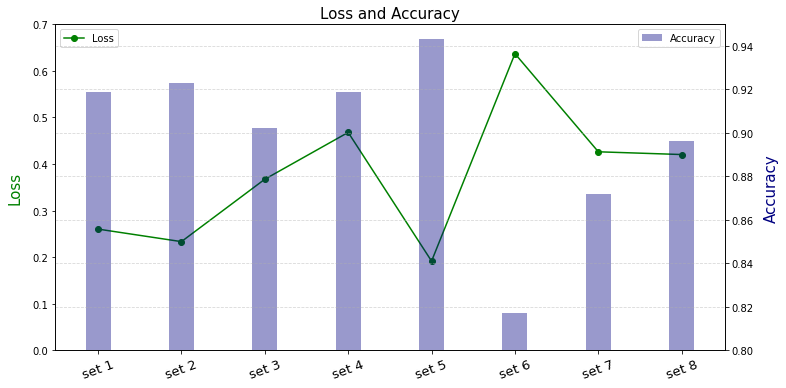

In [ ]:
# loss / acc
plt.figure(figsize=(12,6))

plt.plot( df['loss'], color='green', linewidth=1.5, marker='o', label='Loss')
plt.ylabel('Loss', color='green', labelpad = 10, fontsize=15)
# plt.xlabel('Image Set', fontsize=15)
plt.xticks( rotation = 20, fontsize=13)
plt.ylim(0.0, 0.7)
plt.legend(loc = 'upper left')

ax=plt.gca()
ax2=ax.twinx()

ax2.bar(df.set, df['acc'],alpha=0.4 ,width=0.3, color='navy' , label = 'Accuracy' )
ax2.set_ylabel('Accuracy', color='navy' , labelpad = 10 , fontsize=15)
plt.ylim(0.8, 0.95)
plt.legend(loc = 'upper right')

plt.title('Loss and Accuracy', fontsize=15)
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()

# 리트리버 한계점
- 리트리버의 털은 수북한 특징을 띈다.
- 따라서 객체 윤곽과 배경의 구분이 명확하지 않은 한계점이 존재한다.

# 리트리버 개선사항
- 객체 윤곽과 배경을 뚜렷하게 구분할 수 있게 이미지의 밝기, 대비 등 전처리를 다양하게 적용해보자
- 윤곽을 탐지할 수 있는 코드를 만드는 것도 큰 의미가 있어보인다.